In [ ]:
# loading in and transforming data
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

In [2]:
def get_data_loader(image_type, image_dir='celeba', 
                    image_size=128, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([
        transforms.Resize(image_size), # resize to 128x128
        transforms.CenterCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
#     test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(train_path, transform)
#     test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [3]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data

batch_size = 64
num_workers = 8

dataloader_X, test_dataloader_X = get_data_loader(image_type='no-makeup', image_size=image_size,
                                                  batch_size=batch_size, num_workers=num_workers)
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='makeup', image_size=image_size,
                                                  batch_size=batch_size, num_workers=num_workers)

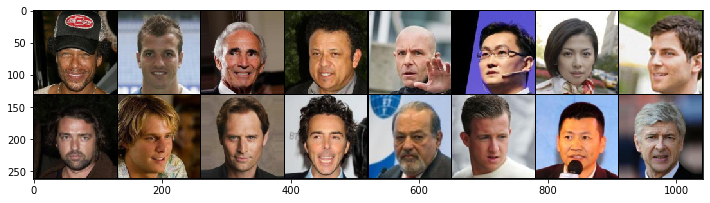

In [4]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images[:16]))

Next, let's visualize a batch of images from set $Y$.

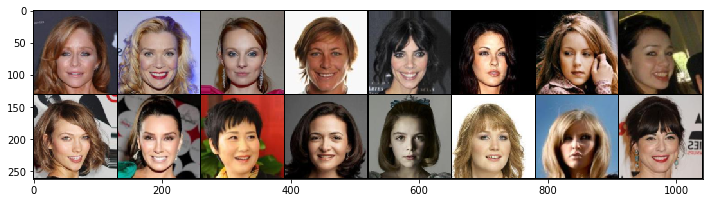

In [5]:
# get some images from Y
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images[:16]))

### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.)
Max:  tensor(0.9490)


In [7]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [8]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-1.)
Scaled max:  tensor(0.8980)


In [9]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value

        # Convolutional layers, increasing in depth
        # first layer has *no* batchnorm
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # x, y = 64, depth 64
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # (32, 32, 128)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # (16, 16, 256)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4) # (8, 8, 512)
        
        # Classification layer
        self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)

    def forward(self, x):
        # relu applied to all conv layers but last
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        # last, classification layer
        out = self.conv5(out)
        return out

In [11]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        
        self.conv_layer1 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                                kernel_size=3, stride=1, padding=1, batch_norm=True)
        
        self.conv_layer2 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                               kernel_size=3, stride=1, padding=1, batch_norm=True)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out_1 = F.relu(self.conv_layer1(x))
        out_2 = x + self.conv_layer2(out_1)
        return out_2
    

In [12]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [13]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator
        
        # initial convolutional layer given, below
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

        # 2. Define the resnet part of the generator
        # Residual blocks
        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))
        # use sequential to create these layers
        self.res_blocks = nn.Sequential(*res_layers)

        # 3. Define the decoder part of the generator
        # two transpose convolutional layers and a third that looks a lot like the initial conv layer
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        # no batch norm on last layer
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary

        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))

        out = self.res_blocks(out)

        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        # tanh applied to last layer
        out = F.tanh(self.deconv3(out))

        return out

In [14]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [15]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU.


In [16]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv_layer1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [17]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    # as absolute value difference between the real and reconstructed images
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    # return weighted loss
    return lambda_weight*reconstr_loss    


In [18]:
import torch.optim as optim

# hyperparams for Adam optimizer
lr=0.0002
beta1=0.5
beta2=0.999 # default value

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

In [19]:
# import save code
from helpers import save_samples, checkpoint

In [20]:
# train the network

def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every=10
    
    # keep track of losses over time
    losses = []
    
    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = iter_Y.next()
        images_Y = scale(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##

        # Train with real images
        d_x_optimizer.zero_grad()

        # 1. Compute the discriminator losses on real images
        out_x = D_X(images_X)
        D_X_real_loss = real_mse_loss(out_x)
        
        # Train with fake images
        
        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 3. Compute the fake loss for D_X
        out_x = D_X(fake_X)
        D_X_fake_loss = fake_mse_loss(out_x)
        

        # 4. Compute the total loss and perform backprop
        d_x_loss = D_X_real_loss + D_X_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()

        
        ##   Second: D_Y, real and fake loss components   ##
        
        # Train with real images
        d_y_optimizer.zero_grad()
        
        # 1. Compute the discriminator losses on real images
        out_y = D_Y(images_Y)
        D_Y_real_loss = real_mse_loss(out_y)
        
        # Train with fake images

        # 2. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 3. Compute the fake loss for D_Y
        out_y = D_Y(fake_Y)
        D_Y_fake_loss = fake_mse_loss(out_y)

        # 4. Compute the total loss and perform backprop
        d_y_loss = D_Y_real_loss + D_Y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()


        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()

        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 2. Compute the generator loss based on domain X
        out_x = D_X(fake_X)
        g_YtoX_loss = real_mse_loss(out_x)

        # 3. Create a reconstructed y
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_Y = G_XtoY(fake_X)
        reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=10)


        ##    Second: generate fake Y images and reconstructed X images    ##

        # 1. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 2. Compute the generator loss based on domain Y
        out_y = D_Y(fake_Y)
        g_XtoY_loss = real_mse_loss(out_y)

        # 3. Create a reconstructed x
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_X = G_YtoX(fake_Y)
        reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=10)

        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
        g_total_loss.backward()
        g_optimizer.step()


        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=batch_size)
            G_YtoX.train()
            G_XtoY.train()

        # uncomment these lines, if you want to save your model
        checkpoint_every=1000
        # Save the model parameters
        if epoch % checkpoint_every == 0:
            checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses


In [21]:
n_epochs = 8000 # keep this small when testing if a model first works

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

Epoch [   10/ 8000] | d_X_loss: 0.2375 | d_Y_loss: 0.2428 | g_total_loss: 9.2709
Epoch [   20/ 8000] | d_X_loss: 0.8380 | d_Y_loss: 0.7311 | g_total_loss: 7.0721
Epoch [   30/ 8000] | d_X_loss: 0.3481 | d_Y_loss: 0.4232 | g_total_loss: 6.6546
Epoch [   40/ 8000] | d_X_loss: 0.4502 | d_Y_loss: 0.3237 | g_total_loss: 8.1411
Epoch [   50/ 8000] | d_X_loss: 0.3667 | d_Y_loss: 0.3225 | g_total_loss: 6.1709
Epoch [   60/ 8000] | d_X_loss: 0.4563 | d_Y_loss: 0.4122 | g_total_loss: 5.0491
Epoch [   70/ 8000] | d_X_loss: 0.3157 | d_Y_loss: 0.4586 | g_total_loss: 4.5438
Epoch [   80/ 8000] | d_X_loss: 0.5524 | d_Y_loss: 0.3905 | g_total_loss: 5.3984
Epoch [   90/ 8000] | d_X_loss: 0.3800 | d_Y_loss: 0.2660 | g_total_loss: 4.5433


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  100/ 8000] | d_X_loss: 0.3628 | d_Y_loss: 0.8121 | g_total_loss: 4.8064


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000100-X-Y.png
Saved samples_cyclegan/sample-000100-Y-X.png
Epoch [  110/ 8000] | d_X_loss: 0.3486 | d_Y_loss: 0.3308 | g_total_loss: 4.6451
Epoch [  120/ 8000] | d_X_loss: 0.6339 | d_Y_loss: 0.2928 | g_total_loss: 6.1656
Epoch [  130/ 8000] | d_X_loss: 0.3909 | d_Y_loss: 0.3172 | g_total_loss: 4.0986
Epoch [  140/ 8000] | d_X_loss: 0.5161 | d_Y_loss: 0.3876 | g_total_loss: 4.8075
Epoch [  150/ 8000] | d_X_loss: 0.3411 | d_Y_loss: 0.2744 | g_total_loss: 4.4423
Epoch [  160/ 8000] | d_X_loss: 0.8231 | d_Y_loss: 0.4209 | g_total_loss: 4.0958
Epoch [  170/ 8000] | d_X_loss: 0.3330 | d_Y_loss: 0.2492 | g_total_loss: 4.2637
Epoch [  180/ 8000] | d_X_loss: 0.6593 | d_Y_loss: 0.3000 | g_total_loss: 5.0648
Epoch [  190/ 8000] | d_X_loss: 0.2932 | d_Y_loss: 0.5147 | g_total_loss: 3.6949


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  200/ 8000] | d_X_loss: 0.6436 | d_Y_loss: 0.3082 | g_total_loss: 8.4038


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000200-X-Y.png
Saved samples_cyclegan/sample-000200-Y-X.png
Epoch [  210/ 8000] | d_X_loss: 0.3426 | d_Y_loss: 0.4928 | g_total_loss: 5.3405
Epoch [  220/ 8000] | d_X_loss: 0.3186 | d_Y_loss: 0.2485 | g_total_loss: 4.5468
Epoch [  230/ 8000] | d_X_loss: 0.3671 | d_Y_loss: 0.2367 | g_total_loss: 4.0394
Epoch [  240/ 8000] | d_X_loss: 0.5120 | d_Y_loss: 0.5615 | g_total_loss: 5.2226
Epoch [  250/ 8000] | d_X_loss: 0.3092 | d_Y_loss: 0.2182 | g_total_loss: 3.7970
Epoch [  260/ 8000] | d_X_loss: 0.4059 | d_Y_loss: 0.2818 | g_total_loss: 4.3640
Epoch [  270/ 8000] | d_X_loss: 0.3023 | d_Y_loss: 0.3801 | g_total_loss: 4.1749
Epoch [  280/ 8000] | d_X_loss: 0.4323 | d_Y_loss: 0.3407 | g_total_loss: 5.6579
Epoch [  290/ 8000] | d_X_loss: 0.3774 | d_Y_loss: 0.2821 | g_total_loss: 3.9980


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  300/ 8000] | d_X_loss: 0.3924 | d_Y_loss: 0.2813 | g_total_loss: 4.7749


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000300-X-Y.png
Saved samples_cyclegan/sample-000300-Y-X.png
Epoch [  310/ 8000] | d_X_loss: 0.2921 | d_Y_loss: 0.2394 | g_total_loss: 5.1633
Epoch [  320/ 8000] | d_X_loss: 0.5068 | d_Y_loss: 0.2922 | g_total_loss: 4.3806
Epoch [  330/ 8000] | d_X_loss: 0.2883 | d_Y_loss: 0.2755 | g_total_loss: 3.4276
Epoch [  340/ 8000] | d_X_loss: 0.4113 | d_Y_loss: 0.3041 | g_total_loss: 5.9316
Epoch [  350/ 8000] | d_X_loss: 0.3177 | d_Y_loss: 0.2245 | g_total_loss: 3.9466
Epoch [  360/ 8000] | d_X_loss: 0.6315 | d_Y_loss: 0.6812 | g_total_loss: 4.4390
Epoch [  370/ 8000] | d_X_loss: 0.2986 | d_Y_loss: 0.2312 | g_total_loss: 3.9222
Epoch [  380/ 8000] | d_X_loss: 0.3951 | d_Y_loss: 0.3576 | g_total_loss: 5.4121
Epoch [  390/ 8000] | d_X_loss: 0.2465 | d_Y_loss: 0.3737 | g_total_loss: 4.6308


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  400/ 8000] | d_X_loss: 1.7069 | d_Y_loss: 0.3193 | g_total_loss: 5.6000


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000400-X-Y.png
Saved samples_cyclegan/sample-000400-Y-X.png
Epoch [  410/ 8000] | d_X_loss: 0.3520 | d_Y_loss: 1.3397 | g_total_loss: 3.1281
Epoch [  420/ 8000] | d_X_loss: 0.3596 | d_Y_loss: 0.2939 | g_total_loss: 3.7127
Epoch [  430/ 8000] | d_X_loss: 0.3302 | d_Y_loss: 0.2214 | g_total_loss: 3.9062
Epoch [  440/ 8000] | d_X_loss: 0.2433 | d_Y_loss: 0.2417 | g_total_loss: 4.2326
Epoch [  450/ 8000] | d_X_loss: 0.2369 | d_Y_loss: 0.1726 | g_total_loss: 3.7841
Epoch [  460/ 8000] | d_X_loss: 0.3171 | d_Y_loss: 0.2093 | g_total_loss: 4.4444
Epoch [  470/ 8000] | d_X_loss: 0.2410 | d_Y_loss: 0.2526 | g_total_loss: 3.9850
Epoch [  480/ 8000] | d_X_loss: 0.3659 | d_Y_loss: 0.1841 | g_total_loss: 4.2976
Epoch [  490/ 8000] | d_X_loss: 0.2552 | d_Y_loss: 0.2388 | g_total_loss: 3.6027


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  500/ 8000] | d_X_loss: 0.7596 | d_Y_loss: 0.3745 | g_total_loss: 4.9164


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000500-X-Y.png
Saved samples_cyclegan/sample-000500-Y-X.png
Epoch [  510/ 8000] | d_X_loss: 0.2708 | d_Y_loss: 0.2103 | g_total_loss: 3.8479
Epoch [  520/ 8000] | d_X_loss: 0.4659 | d_Y_loss: 0.2068 | g_total_loss: 3.4015
Epoch [  530/ 8000] | d_X_loss: 0.2546 | d_Y_loss: 0.2118 | g_total_loss: 3.5514
Epoch [  540/ 8000] | d_X_loss: 0.4033 | d_Y_loss: 0.1800 | g_total_loss: 6.5519
Epoch [  550/ 8000] | d_X_loss: 0.3056 | d_Y_loss: 0.2947 | g_total_loss: 3.2442
Epoch [  560/ 8000] | d_X_loss: 0.2926 | d_Y_loss: 0.1473 | g_total_loss: 4.4563
Epoch [  570/ 8000] | d_X_loss: 0.2427 | d_Y_loss: 0.1796 | g_total_loss: 4.0291
Epoch [  580/ 8000] | d_X_loss: 0.3202 | d_Y_loss: 0.5582 | g_total_loss: 5.1543
Epoch [  590/ 8000] | d_X_loss: 0.2091 | d_Y_loss: 0.1865 | g_total_loss: 3.5717


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  600/ 8000] | d_X_loss: 0.1927 | d_Y_loss: 0.1473 | g_total_loss: 4.8003


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000600-X-Y.png
Saved samples_cyclegan/sample-000600-Y-X.png
Epoch [  610/ 8000] | d_X_loss: 0.2624 | d_Y_loss: 0.1509 | g_total_loss: 3.6638
Epoch [  620/ 8000] | d_X_loss: 0.2982 | d_Y_loss: 0.4940 | g_total_loss: 4.3201
Epoch [  630/ 8000] | d_X_loss: 0.2082 | d_Y_loss: 0.2231 | g_total_loss: 4.3007
Epoch [  640/ 8000] | d_X_loss: 0.4127 | d_Y_loss: 0.2883 | g_total_loss: 4.9341
Epoch [  650/ 8000] | d_X_loss: 0.2319 | d_Y_loss: 0.2266 | g_total_loss: 3.6567
Epoch [  660/ 8000] | d_X_loss: 0.2597 | d_Y_loss: 0.4237 | g_total_loss: 5.6270
Epoch [  670/ 8000] | d_X_loss: 0.2706 | d_Y_loss: 0.1821 | g_total_loss: 3.4396
Epoch [  680/ 8000] | d_X_loss: 1.3273 | d_Y_loss: 0.2616 | g_total_loss: 5.0485
Epoch [  690/ 8000] | d_X_loss: 0.3867 | d_Y_loss: 0.1969 | g_total_loss: 3.2819


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  700/ 8000] | d_X_loss: 0.3516 | d_Y_loss: 0.2106 | g_total_loss: 5.0131


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000700-X-Y.png
Saved samples_cyclegan/sample-000700-Y-X.png
Epoch [  710/ 8000] | d_X_loss: 0.2734 | d_Y_loss: 0.1937 | g_total_loss: 4.0222
Epoch [  720/ 8000] | d_X_loss: 0.3049 | d_Y_loss: 0.6012 | g_total_loss: 3.5464
Epoch [  730/ 8000] | d_X_loss: 0.3474 | d_Y_loss: 0.3073 | g_total_loss: 3.7701
Epoch [  740/ 8000] | d_X_loss: 0.3736 | d_Y_loss: 0.8613 | g_total_loss: 5.2031
Epoch [  750/ 8000] | d_X_loss: 0.2334 | d_Y_loss: 0.2495 | g_total_loss: 3.7960
Epoch [  760/ 8000] | d_X_loss: 0.4290 | d_Y_loss: 0.1759 | g_total_loss: 4.9582
Epoch [  770/ 8000] | d_X_loss: 0.3289 | d_Y_loss: 0.4138 | g_total_loss: 4.6312
Epoch [  780/ 8000] | d_X_loss: 0.4141 | d_Y_loss: 0.1809 | g_total_loss: 4.7848
Epoch [  790/ 8000] | d_X_loss: 0.3054 | d_Y_loss: 0.2516 | g_total_loss: 3.6671


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  800/ 8000] | d_X_loss: 0.9545 | d_Y_loss: 0.5756 | g_total_loss: 4.6215


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000800-X-Y.png
Saved samples_cyclegan/sample-000800-Y-X.png
Epoch [  810/ 8000] | d_X_loss: 0.2627 | d_Y_loss: 0.2542 | g_total_loss: 3.7667
Epoch [  820/ 8000] | d_X_loss: 0.6608 | d_Y_loss: 0.2816 | g_total_loss: 4.6908
Epoch [  830/ 8000] | d_X_loss: 0.3161 | d_Y_loss: 0.1794 | g_total_loss: 3.7851
Epoch [  840/ 8000] | d_X_loss: 0.3629 | d_Y_loss: 0.3333 | g_total_loss: 4.8056
Epoch [  850/ 8000] | d_X_loss: 0.3086 | d_Y_loss: 0.2384 | g_total_loss: 3.9564
Epoch [  860/ 8000] | d_X_loss: 0.5774 | d_Y_loss: 0.2698 | g_total_loss: 5.4758
Epoch [  870/ 8000] | d_X_loss: 0.3599 | d_Y_loss: 0.2929 | g_total_loss: 3.0684
Epoch [  880/ 8000] | d_X_loss: 0.5371 | d_Y_loss: 0.1677 | g_total_loss: 5.8530
Epoch [  890/ 8000] | d_X_loss: 0.2677 | d_Y_loss: 0.2832 | g_total_loss: 3.9745


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  900/ 8000] | d_X_loss: 0.2262 | d_Y_loss: 0.2403 | g_total_loss: 4.4337


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000900-X-Y.png
Saved samples_cyclegan/sample-000900-Y-X.png
Epoch [  910/ 8000] | d_X_loss: 0.3374 | d_Y_loss: 0.2397 | g_total_loss: 4.1193
Epoch [  920/ 8000] | d_X_loss: 0.4787 | d_Y_loss: 0.7802 | g_total_loss: 5.5969
Epoch [  930/ 8000] | d_X_loss: 0.2750 | d_Y_loss: 0.2704 | g_total_loss: 3.5985
Epoch [  940/ 8000] | d_X_loss: 0.3554 | d_Y_loss: 0.2411 | g_total_loss: 5.1507
Epoch [  950/ 8000] | d_X_loss: 0.3577 | d_Y_loss: 0.2013 | g_total_loss: 4.1317
Epoch [  960/ 8000] | d_X_loss: 0.2745 | d_Y_loss: 0.5008 | g_total_loss: 3.9823
Epoch [  970/ 8000] | d_X_loss: 0.2477 | d_Y_loss: 0.1990 | g_total_loss: 3.6362
Epoch [  980/ 8000] | d_X_loss: 0.4701 | d_Y_loss: 0.3884 | g_total_loss: 5.1267
Epoch [  990/ 8000] | d_X_loss: 0.3194 | d_Y_loss: 0.2129 | g_total_loss: 3.3353


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1000/ 8000] | d_X_loss: 1.4560 | d_Y_loss: 0.7640 | g_total_loss: 5.2665


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001000-X-Y.png
Saved samples_cyclegan/sample-001000-Y-X.png
Epoch [ 1010/ 8000] | d_X_loss: 0.3063 | d_Y_loss: 0.3086 | g_total_loss: 3.2559
Epoch [ 1020/ 8000] | d_X_loss: 0.2911 | d_Y_loss: 0.2691 | g_total_loss: 3.9960
Epoch [ 1030/ 8000] | d_X_loss: 0.3166 | d_Y_loss: 0.3362 | g_total_loss: 3.2033
Epoch [ 1040/ 8000] | d_X_loss: 0.3648 | d_Y_loss: 0.1151 | g_total_loss: 4.7878
Epoch [ 1050/ 8000] | d_X_loss: 0.2829 | d_Y_loss: 0.2533 | g_total_loss: 3.1734
Epoch [ 1060/ 8000] | d_X_loss: 0.3580 | d_Y_loss: 0.2024 | g_total_loss: 4.4267
Epoch [ 1070/ 8000] | d_X_loss: 0.2640 | d_Y_loss: 0.2055 | g_total_loss: 3.4798
Epoch [ 1080/ 8000] | d_X_loss: 0.7696 | d_Y_loss: 0.1478 | g_total_loss: 3.6043
Epoch [ 1090/ 8000] | d_X_loss: 0.2427 | d_Y_loss: 0.3531 | g_total_loss: 3.3548


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1100/ 8000] | d_X_loss: 0.2769 | d_Y_loss: 0.1846 | g_total_loss: 4.5076


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001100-X-Y.png
Saved samples_cyclegan/sample-001100-Y-X.png
Epoch [ 1110/ 8000] | d_X_loss: 0.6614 | d_Y_loss: 0.1742 | g_total_loss: 3.6183
Epoch [ 1120/ 8000] | d_X_loss: 0.3128 | d_Y_loss: 0.5564 | g_total_loss: 4.6214
Epoch [ 1130/ 8000] | d_X_loss: 0.2927 | d_Y_loss: 0.2322 | g_total_loss: 3.8635
Epoch [ 1140/ 8000] | d_X_loss: 0.3454 | d_Y_loss: 0.7078 | g_total_loss: 5.7095
Epoch [ 1150/ 8000] | d_X_loss: 0.3315 | d_Y_loss: 0.3312 | g_total_loss: 2.9363
Epoch [ 1160/ 8000] | d_X_loss: 0.7651 | d_Y_loss: 0.3956 | g_total_loss: 4.7401
Epoch [ 1170/ 8000] | d_X_loss: 0.2022 | d_Y_loss: 0.2020 | g_total_loss: 3.7130
Epoch [ 1180/ 8000] | d_X_loss: 0.3302 | d_Y_loss: 0.4493 | g_total_loss: 5.7691
Epoch [ 1190/ 8000] | d_X_loss: 0.2043 | d_Y_loss: 0.2267 | g_total_loss: 3.6623


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1200/ 8000] | d_X_loss: 0.3139 | d_Y_loss: 0.8178 | g_total_loss: 5.5092


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001200-X-Y.png
Saved samples_cyclegan/sample-001200-Y-X.png
Epoch [ 1210/ 8000] | d_X_loss: 0.2445 | d_Y_loss: 0.2632 | g_total_loss: 3.3585
Epoch [ 1220/ 8000] | d_X_loss: 0.2702 | d_Y_loss: 0.4169 | g_total_loss: 4.7601
Epoch [ 1230/ 8000] | d_X_loss: 0.2637 | d_Y_loss: 0.1924 | g_total_loss: 4.2904
Epoch [ 1240/ 8000] | d_X_loss: 0.1904 | d_Y_loss: 0.5166 | g_total_loss: 5.1254
Epoch [ 1250/ 8000] | d_X_loss: 0.3546 | d_Y_loss: 0.2068 | g_total_loss: 4.0262
Epoch [ 1260/ 8000] | d_X_loss: 1.6845 | d_Y_loss: 0.5210 | g_total_loss: 4.2815
Epoch [ 1270/ 8000] | d_X_loss: 0.4208 | d_Y_loss: 0.1836 | g_total_loss: 3.4717
Epoch [ 1280/ 8000] | d_X_loss: 0.4440 | d_Y_loss: 0.5232 | g_total_loss: 4.7628
Epoch [ 1290/ 8000] | d_X_loss: 0.3270 | d_Y_loss: 0.2220 | g_total_loss: 3.1117


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1300/ 8000] | d_X_loss: 0.2834 | d_Y_loss: 0.1680 | g_total_loss: 4.3297


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001300-X-Y.png
Saved samples_cyclegan/sample-001300-Y-X.png
Epoch [ 1310/ 8000] | d_X_loss: 0.3032 | d_Y_loss: 0.1938 | g_total_loss: 3.1339
Epoch [ 1320/ 8000] | d_X_loss: 0.4903 | d_Y_loss: 0.1580 | g_total_loss: 4.7582
Epoch [ 1330/ 8000] | d_X_loss: 0.2780 | d_Y_loss: 0.1853 | g_total_loss: 3.3647
Epoch [ 1340/ 8000] | d_X_loss: 0.2476 | d_Y_loss: 0.2838 | g_total_loss: 3.7335
Epoch [ 1350/ 8000] | d_X_loss: 0.3053 | d_Y_loss: 0.1778 | g_total_loss: 3.8133
Epoch [ 1360/ 8000] | d_X_loss: 0.6425 | d_Y_loss: 0.2625 | g_total_loss: 4.9665
Epoch [ 1370/ 8000] | d_X_loss: 0.3204 | d_Y_loss: 0.2141 | g_total_loss: 3.3496
Epoch [ 1380/ 8000] | d_X_loss: 0.2464 | d_Y_loss: 0.5185 | g_total_loss: 4.8732
Epoch [ 1390/ 8000] | d_X_loss: 0.3368 | d_Y_loss: 0.2203 | g_total_loss: 3.1544


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1400/ 8000] | d_X_loss: 1.6602 | d_Y_loss: 1.0184 | g_total_loss: 4.8034


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001400-X-Y.png
Saved samples_cyclegan/sample-001400-Y-X.png
Epoch [ 1410/ 8000] | d_X_loss: 0.3543 | d_Y_loss: 0.2618 | g_total_loss: 2.8799
Epoch [ 1420/ 8000] | d_X_loss: 0.3035 | d_Y_loss: 0.2518 | g_total_loss: 4.1290
Epoch [ 1430/ 8000] | d_X_loss: 0.2953 | d_Y_loss: 0.1714 | g_total_loss: 2.7160
Epoch [ 1440/ 8000] | d_X_loss: 0.3609 | d_Y_loss: 0.5514 | g_total_loss: 5.9835
Epoch [ 1450/ 8000] | d_X_loss: 0.2852 | d_Y_loss: 0.2329 | g_total_loss: 4.1968
Epoch [ 1460/ 8000] | d_X_loss: 0.1865 | d_Y_loss: 0.8188 | g_total_loss: 5.5803
Epoch [ 1470/ 8000] | d_X_loss: 0.2156 | d_Y_loss: 0.4694 | g_total_loss: 3.4704
Epoch [ 1480/ 8000] | d_X_loss: 0.2308 | d_Y_loss: 0.4892 | g_total_loss: 3.2941
Epoch [ 1490/ 8000] | d_X_loss: 0.2719 | d_Y_loss: 0.3895 | g_total_loss: 2.9665


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1500/ 8000] | d_X_loss: 0.6123 | d_Y_loss: 0.3742 | g_total_loss: 2.7454


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001500-X-Y.png
Saved samples_cyclegan/sample-001500-Y-X.png
Epoch [ 1510/ 8000] | d_X_loss: 0.1709 | d_Y_loss: 0.2736 | g_total_loss: 3.2117
Epoch [ 1520/ 8000] | d_X_loss: 0.2789 | d_Y_loss: 0.4582 | g_total_loss: 3.7211
Epoch [ 1530/ 8000] | d_X_loss: 0.2260 | d_Y_loss: 0.2570 | g_total_loss: 3.8842
Epoch [ 1540/ 8000] | d_X_loss: 0.1879 | d_Y_loss: 0.2386 | g_total_loss: 4.0500
Epoch [ 1550/ 8000] | d_X_loss: 0.2574 | d_Y_loss: 0.2435 | g_total_loss: 3.7707
Epoch [ 1560/ 8000] | d_X_loss: 0.1659 | d_Y_loss: 0.1392 | g_total_loss: 5.2673
Epoch [ 1570/ 8000] | d_X_loss: 0.2124 | d_Y_loss: 0.1114 | g_total_loss: 3.7048
Epoch [ 1580/ 8000] | d_X_loss: 0.3648 | d_Y_loss: 0.2635 | g_total_loss: 5.9943
Epoch [ 1590/ 8000] | d_X_loss: 0.2664 | d_Y_loss: 0.1752 | g_total_loss: 3.1403


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1600/ 8000] | d_X_loss: 0.4101 | d_Y_loss: 0.4061 | g_total_loss: 4.2110


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001600-X-Y.png
Saved samples_cyclegan/sample-001600-Y-X.png
Epoch [ 1610/ 8000] | d_X_loss: 0.2538 | d_Y_loss: 0.1948 | g_total_loss: 3.2359
Epoch [ 1620/ 8000] | d_X_loss: 0.3892 | d_Y_loss: 0.2623 | g_total_loss: 3.7303
Epoch [ 1630/ 8000] | d_X_loss: 0.2478 | d_Y_loss: 0.1821 | g_total_loss: 3.1847
Epoch [ 1640/ 8000] | d_X_loss: 0.5193 | d_Y_loss: 0.1674 | g_total_loss: 5.1646
Epoch [ 1650/ 8000] | d_X_loss: 0.2570 | d_Y_loss: 0.1962 | g_total_loss: 3.5045
Epoch [ 1660/ 8000] | d_X_loss: 0.3003 | d_Y_loss: 0.5301 | g_total_loss: 4.8797
Epoch [ 1670/ 8000] | d_X_loss: 0.1964 | d_Y_loss: 0.2136 | g_total_loss: 2.9844
Epoch [ 1680/ 8000] | d_X_loss: 0.4390 | d_Y_loss: 0.5034 | g_total_loss: 6.0072
Epoch [ 1690/ 8000] | d_X_loss: 0.1773 | d_Y_loss: 0.1873 | g_total_loss: 3.8372


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1700/ 8000] | d_X_loss: 0.3776 | d_Y_loss: 0.2044 | g_total_loss: 4.1765


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001700-X-Y.png
Saved samples_cyclegan/sample-001700-Y-X.png
Epoch [ 1710/ 8000] | d_X_loss: 0.2678 | d_Y_loss: 0.1878 | g_total_loss: 3.4474
Epoch [ 1720/ 8000] | d_X_loss: 0.2707 | d_Y_loss: 0.2110 | g_total_loss: 3.8787
Epoch [ 1730/ 8000] | d_X_loss: 0.1536 | d_Y_loss: 0.1396 | g_total_loss: 3.9721
Epoch [ 1740/ 8000] | d_X_loss: 0.9221 | d_Y_loss: 0.6123 | g_total_loss: 3.7763
Epoch [ 1750/ 8000] | d_X_loss: 0.2809 | d_Y_loss: 0.1935 | g_total_loss: 3.1292
Epoch [ 1760/ 8000] | d_X_loss: 0.3472 | d_Y_loss: 0.9307 | g_total_loss: 4.9898
Epoch [ 1770/ 8000] | d_X_loss: 0.1888 | d_Y_loss: 0.2437 | g_total_loss: 3.5804
Epoch [ 1780/ 8000] | d_X_loss: 0.2940 | d_Y_loss: 0.2992 | g_total_loss: 4.1777
Epoch [ 1790/ 8000] | d_X_loss: 0.2158 | d_Y_loss: 0.1769 | g_total_loss: 3.6173


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1800/ 8000] | d_X_loss: 0.3210 | d_Y_loss: 0.2675 | g_total_loss: 4.7262


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001800-X-Y.png
Saved samples_cyclegan/sample-001800-Y-X.png
Epoch [ 1810/ 8000] | d_X_loss: 0.4109 | d_Y_loss: 0.1970 | g_total_loss: 4.1389
Epoch [ 1820/ 8000] | d_X_loss: 0.3121 | d_Y_loss: 0.1466 | g_total_loss: 3.5277
Epoch [ 1830/ 8000] | d_X_loss: 0.3737 | d_Y_loss: 0.3299 | g_total_loss: 2.9299
Epoch [ 1840/ 8000] | d_X_loss: 1.1743 | d_Y_loss: 0.5897 | g_total_loss: 4.0030
Epoch [ 1850/ 8000] | d_X_loss: 0.2314 | d_Y_loss: 0.2060 | g_total_loss: 3.1680
Epoch [ 1860/ 8000] | d_X_loss: 0.3025 | d_Y_loss: 0.4726 | g_total_loss: 5.0433
Epoch [ 1870/ 8000] | d_X_loss: 0.2546 | d_Y_loss: 0.2131 | g_total_loss: 3.2526
Epoch [ 1880/ 8000] | d_X_loss: 0.3461 | d_Y_loss: 0.1587 | g_total_loss: 4.3056
Epoch [ 1890/ 8000] | d_X_loss: 0.2868 | d_Y_loss: 0.2060 | g_total_loss: 3.0632


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1900/ 8000] | d_X_loss: 0.2960 | d_Y_loss: 0.4214 | g_total_loss: 5.1951


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001900-X-Y.png
Saved samples_cyclegan/sample-001900-Y-X.png
Epoch [ 1910/ 8000] | d_X_loss: 0.3217 | d_Y_loss: 0.1978 | g_total_loss: 3.0381
Epoch [ 1920/ 8000] | d_X_loss: 0.2602 | d_Y_loss: 0.3704 | g_total_loss: 4.2205
Epoch [ 1930/ 8000] | d_X_loss: 0.3304 | d_Y_loss: 0.1482 | g_total_loss: 3.3298
Epoch [ 1940/ 8000] | d_X_loss: 1.1476 | d_Y_loss: 0.1323 | g_total_loss: 3.9219
Epoch [ 1950/ 8000] | d_X_loss: 0.4004 | d_Y_loss: 0.1153 | g_total_loss: 3.3904
Epoch [ 1960/ 8000] | d_X_loss: 0.4378 | d_Y_loss: 0.1542 | g_total_loss: 3.7417
Epoch [ 1970/ 8000] | d_X_loss: 0.3486 | d_Y_loss: 0.1587 | g_total_loss: 3.1653
Epoch [ 1980/ 8000] | d_X_loss: 0.2819 | d_Y_loss: 0.2503 | g_total_loss: 5.0971
Epoch [ 1990/ 8000] | d_X_loss: 0.2573 | d_Y_loss: 0.1450 | g_total_loss: 3.4230


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2000/ 8000] | d_X_loss: 0.2512 | d_Y_loss: 0.3930 | g_total_loss: 4.6474


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002000-X-Y.png
Saved samples_cyclegan/sample-002000-Y-X.png
Epoch [ 2010/ 8000] | d_X_loss: 0.2248 | d_Y_loss: 0.1563 | g_total_loss: 3.4851
Epoch [ 2020/ 8000] | d_X_loss: 0.3616 | d_Y_loss: 0.2120 | g_total_loss: 8.4318
Epoch [ 2030/ 8000] | d_X_loss: 0.1486 | d_Y_loss: 0.0785 | g_total_loss: 4.1865
Epoch [ 2040/ 8000] | d_X_loss: 0.2744 | d_Y_loss: 0.2279 | g_total_loss: 4.0373
Epoch [ 2050/ 8000] | d_X_loss: 0.1352 | d_Y_loss: 0.1239 | g_total_loss: 3.6215
Epoch [ 2060/ 8000] | d_X_loss: 0.5789 | d_Y_loss: 0.5193 | g_total_loss: 3.4900
Epoch [ 2070/ 8000] | d_X_loss: 0.1968 | d_Y_loss: 0.2389 | g_total_loss: 3.0722
Epoch [ 2080/ 8000] | d_X_loss: 0.2885 | d_Y_loss: 0.4462 | g_total_loss: 3.4452
Epoch [ 2090/ 8000] | d_X_loss: 0.1659 | d_Y_loss: 0.1596 | g_total_loss: 3.2631


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2100/ 8000] | d_X_loss: 0.6601 | d_Y_loss: 0.2266 | g_total_loss: 5.3533


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002100-X-Y.png
Saved samples_cyclegan/sample-002100-Y-X.png
Epoch [ 2110/ 8000] | d_X_loss: 0.2308 | d_Y_loss: 0.2235 | g_total_loss: 4.0918
Epoch [ 2120/ 8000] | d_X_loss: 0.2405 | d_Y_loss: 0.1548 | g_total_loss: 3.8200
Epoch [ 2130/ 8000] | d_X_loss: 0.2812 | d_Y_loss: 0.1462 | g_total_loss: 3.9181
Epoch [ 2140/ 8000] | d_X_loss: 1.4009 | d_Y_loss: 0.2024 | g_total_loss: 3.4559
Epoch [ 2150/ 8000] | d_X_loss: 0.2469 | d_Y_loss: 0.1511 | g_total_loss: 3.4907
Epoch [ 2160/ 8000] | d_X_loss: 0.2982 | d_Y_loss: 0.3196 | g_total_loss: 4.0250
Epoch [ 2170/ 8000] | d_X_loss: 0.1710 | d_Y_loss: 0.1773 | g_total_loss: 3.5042
Epoch [ 2180/ 8000] | d_X_loss: 0.3291 | d_Y_loss: 0.5483 | g_total_loss: 6.5684
Epoch [ 2190/ 8000] | d_X_loss: 0.1275 | d_Y_loss: 0.2230 | g_total_loss: 3.3787


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2200/ 8000] | d_X_loss: 0.3272 | d_Y_loss: 0.2039 | g_total_loss: 5.0774


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002200-X-Y.png
Saved samples_cyclegan/sample-002200-Y-X.png
Epoch [ 2210/ 8000] | d_X_loss: 0.2328 | d_Y_loss: 0.1946 | g_total_loss: 3.5869
Epoch [ 2220/ 8000] | d_X_loss: 0.2220 | d_Y_loss: 0.0654 | g_total_loss: 5.3517
Epoch [ 2230/ 8000] | d_X_loss: 0.0861 | d_Y_loss: 0.0680 | g_total_loss: 4.0956
Epoch [ 2240/ 8000] | d_X_loss: 0.3312 | d_Y_loss: 0.1031 | g_total_loss: 4.6412
Epoch [ 2250/ 8000] | d_X_loss: 0.1395 | d_Y_loss: 0.0956 | g_total_loss: 4.3649
Epoch [ 2260/ 8000] | d_X_loss: 0.8999 | d_Y_loss: 1.0688 | g_total_loss: 5.5054
Epoch [ 2270/ 8000] | d_X_loss: 0.1912 | d_Y_loss: 0.3563 | g_total_loss: 3.7779
Epoch [ 2280/ 8000] | d_X_loss: 0.1305 | d_Y_loss: 0.1746 | g_total_loss: 3.9001
Epoch [ 2290/ 8000] | d_X_loss: 0.2266 | d_Y_loss: 0.1837 | g_total_loss: 4.0770


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2300/ 8000] | d_X_loss: 0.3346 | d_Y_loss: 0.2771 | g_total_loss: 4.6793


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002300-X-Y.png
Saved samples_cyclegan/sample-002300-Y-X.png
Epoch [ 2310/ 8000] | d_X_loss: 0.2073 | d_Y_loss: 0.1582 | g_total_loss: 3.3245
Epoch [ 2320/ 8000] | d_X_loss: 0.3354 | d_Y_loss: 0.3244 | g_total_loss: 4.9334
Epoch [ 2330/ 8000] | d_X_loss: 0.2812 | d_Y_loss: 0.2110 | g_total_loss: 3.5654
Epoch [ 2340/ 8000] | d_X_loss: 0.3766 | d_Y_loss: 0.4013 | g_total_loss: 6.1632
Epoch [ 2350/ 8000] | d_X_loss: 0.1589 | d_Y_loss: 0.1674 | g_total_loss: 3.3336
Epoch [ 2360/ 8000] | d_X_loss: 0.4596 | d_Y_loss: 0.2297 | g_total_loss: 4.1914
Epoch [ 2370/ 8000] | d_X_loss: 0.1977 | d_Y_loss: 0.2224 | g_total_loss: 3.6705
Epoch [ 2380/ 8000] | d_X_loss: 0.3369 | d_Y_loss: 0.2073 | g_total_loss: 4.9187
Epoch [ 2390/ 8000] | d_X_loss: 0.2044 | d_Y_loss: 0.1593 | g_total_loss: 3.2616


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2400/ 8000] | d_X_loss: 0.4747 | d_Y_loss: 0.5829 | g_total_loss: 4.8278


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002400-X-Y.png
Saved samples_cyclegan/sample-002400-Y-X.png
Epoch [ 2410/ 8000] | d_X_loss: 0.1687 | d_Y_loss: 0.1737 | g_total_loss: 3.5816
Epoch [ 2420/ 8000] | d_X_loss: 0.1185 | d_Y_loss: 0.0747 | g_total_loss: 5.4474
Epoch [ 2430/ 8000] | d_X_loss: 0.2623 | d_Y_loss: 0.1294 | g_total_loss: 3.4838
Epoch [ 2440/ 8000] | d_X_loss: 0.2234 | d_Y_loss: 0.2117 | g_total_loss: 5.4151
Epoch [ 2450/ 8000] | d_X_loss: 0.4624 | d_Y_loss: 0.1303 | g_total_loss: 4.3816
Epoch [ 2460/ 8000] | d_X_loss: 0.2299 | d_Y_loss: 0.4097 | g_total_loss: 4.9246
Epoch [ 2470/ 8000] | d_X_loss: 0.1296 | d_Y_loss: 0.1800 | g_total_loss: 3.7297
Epoch [ 2480/ 8000] | d_X_loss: 0.2020 | d_Y_loss: 0.4329 | g_total_loss: 3.3736
Epoch [ 2490/ 8000] | d_X_loss: 0.2178 | d_Y_loss: 0.3255 | g_total_loss: 4.0575


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2500/ 8000] | d_X_loss: 0.3604 | d_Y_loss: 0.1738 | g_total_loss: 4.3143


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002500-X-Y.png
Saved samples_cyclegan/sample-002500-Y-X.png
Epoch [ 2510/ 8000] | d_X_loss: 0.1796 | d_Y_loss: 0.2538 | g_total_loss: 4.1468
Epoch [ 2520/ 8000] | d_X_loss: 0.2799 | d_Y_loss: 0.5497 | g_total_loss: 5.1884
Epoch [ 2530/ 8000] | d_X_loss: 0.3077 | d_Y_loss: 0.1748 | g_total_loss: 3.0362
Epoch [ 2540/ 8000] | d_X_loss: 0.6698 | d_Y_loss: 0.4828 | g_total_loss: 4.0944
Epoch [ 2550/ 8000] | d_X_loss: 0.2162 | d_Y_loss: 0.1540 | g_total_loss: 3.3219
Epoch [ 2560/ 8000] | d_X_loss: 0.1512 | d_Y_loss: 0.2032 | g_total_loss: 4.7981
Epoch [ 2570/ 8000] | d_X_loss: 0.1463 | d_Y_loss: 0.1430 | g_total_loss: 3.8814
Epoch [ 2580/ 8000] | d_X_loss: 0.2324 | d_Y_loss: 0.6183 | g_total_loss: 5.8505
Epoch [ 2590/ 8000] | d_X_loss: 0.2977 | d_Y_loss: 0.2165 | g_total_loss: 3.6056


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2600/ 8000] | d_X_loss: 0.3019 | d_Y_loss: 0.3024 | g_total_loss: 4.3715


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002600-X-Y.png
Saved samples_cyclegan/sample-002600-Y-X.png
Epoch [ 2610/ 8000] | d_X_loss: 0.2211 | d_Y_loss: 0.1354 | g_total_loss: 3.5391
Epoch [ 2620/ 8000] | d_X_loss: 0.6718 | d_Y_loss: 0.0992 | g_total_loss: 4.0774
Epoch [ 2630/ 8000] | d_X_loss: 0.2370 | d_Y_loss: 0.1126 | g_total_loss: 3.6827
Epoch [ 2640/ 8000] | d_X_loss: 0.2131 | d_Y_loss: 0.2825 | g_total_loss: 4.0381
Epoch [ 2650/ 8000] | d_X_loss: 0.2232 | d_Y_loss: 0.1756 | g_total_loss: 3.7302
Epoch [ 2660/ 8000] | d_X_loss: 0.2721 | d_Y_loss: 0.4593 | g_total_loss: 5.1153
Epoch [ 2670/ 8000] | d_X_loss: 0.2297 | d_Y_loss: 0.1608 | g_total_loss: 3.3085
Epoch [ 2680/ 8000] | d_X_loss: 0.6768 | d_Y_loss: 0.3613 | g_total_loss: 4.7095
Epoch [ 2690/ 8000] | d_X_loss: 0.1828 | d_Y_loss: 0.1434 | g_total_loss: 3.2324


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2700/ 8000] | d_X_loss: 0.4313 | d_Y_loss: 0.6875 | g_total_loss: 5.8856


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002700-X-Y.png
Saved samples_cyclegan/sample-002700-Y-X.png
Epoch [ 2710/ 8000] | d_X_loss: 0.2460 | d_Y_loss: 0.1598 | g_total_loss: 3.4537
Epoch [ 2720/ 8000] | d_X_loss: 0.2563 | d_Y_loss: 0.1712 | g_total_loss: 3.4942
Epoch [ 2730/ 8000] | d_X_loss: 0.3699 | d_Y_loss: 0.1406 | g_total_loss: 3.0233
Epoch [ 2740/ 8000] | d_X_loss: 0.3022 | d_Y_loss: 0.4579 | g_total_loss: 5.0403
Epoch [ 2750/ 8000] | d_X_loss: 0.2488 | d_Y_loss: 0.1800 | g_total_loss: 3.1049
Epoch [ 2760/ 8000] | d_X_loss: 0.2571 | d_Y_loss: 0.1279 | g_total_loss: 4.4808
Epoch [ 2770/ 8000] | d_X_loss: 0.4064 | d_Y_loss: 0.0988 | g_total_loss: 3.2767
Epoch [ 2780/ 8000] | d_X_loss: 0.2343 | d_Y_loss: 0.1240 | g_total_loss: 3.3408
Epoch [ 2790/ 8000] | d_X_loss: 0.1766 | d_Y_loss: 0.0723 | g_total_loss: 3.0918


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2800/ 8000] | d_X_loss: 0.2102 | d_Y_loss: 0.1758 | g_total_loss: 3.5112


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002800-X-Y.png
Saved samples_cyclegan/sample-002800-Y-X.png
Epoch [ 2810/ 8000] | d_X_loss: 0.1708 | d_Y_loss: 0.1485 | g_total_loss: 3.5923
Epoch [ 2820/ 8000] | d_X_loss: 1.1455 | d_Y_loss: 0.2021 | g_total_loss: 4.9467
Epoch [ 2830/ 8000] | d_X_loss: 0.2014 | d_Y_loss: 0.1570 | g_total_loss: 3.5111
Epoch [ 2840/ 8000] | d_X_loss: 0.3961 | d_Y_loss: 0.5858 | g_total_loss: 5.5141
Epoch [ 2850/ 8000] | d_X_loss: 0.1889 | d_Y_loss: 0.1416 | g_total_loss: 3.3548
Epoch [ 2860/ 8000] | d_X_loss: 0.2734 | d_Y_loss: 0.1770 | g_total_loss: 4.6129
Epoch [ 2870/ 8000] | d_X_loss: 0.3427 | d_Y_loss: 0.2654 | g_total_loss: 3.6473
Epoch [ 2880/ 8000] | d_X_loss: 1.0701 | d_Y_loss: 0.1055 | g_total_loss: 2.9771
Epoch [ 2890/ 8000] | d_X_loss: 0.2362 | d_Y_loss: 0.3298 | g_total_loss: 3.9248


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2900/ 8000] | d_X_loss: 0.2091 | d_Y_loss: 0.2815 | g_total_loss: 4.7026


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002900-X-Y.png
Saved samples_cyclegan/sample-002900-Y-X.png
Epoch [ 2910/ 8000] | d_X_loss: 0.0830 | d_Y_loss: 0.1978 | g_total_loss: 4.1865
Epoch [ 2920/ 8000] | d_X_loss: 0.2512 | d_Y_loss: 0.1012 | g_total_loss: 3.8570
Epoch [ 2930/ 8000] | d_X_loss: 0.2781 | d_Y_loss: 0.1029 | g_total_loss: 3.9456
Epoch [ 2940/ 8000] | d_X_loss: 0.4618 | d_Y_loss: 0.3438 | g_total_loss: 3.6285
Epoch [ 2950/ 8000] | d_X_loss: 0.1355 | d_Y_loss: 0.1452 | g_total_loss: 3.5920
Epoch [ 2960/ 8000] | d_X_loss: 0.2624 | d_Y_loss: 0.3659 | g_total_loss: 5.4839
Epoch [ 2970/ 8000] | d_X_loss: 0.2521 | d_Y_loss: 0.6967 | g_total_loss: 3.4635
Epoch [ 2980/ 8000] | d_X_loss: 0.8565 | d_Y_loss: 0.4286 | g_total_loss: 2.8897
Epoch [ 2990/ 8000] | d_X_loss: 0.1244 | d_Y_loss: 0.2218 | g_total_loss: 3.6642


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3000/ 8000] | d_X_loss: 0.2136 | d_Y_loss: 0.2099 | g_total_loss: 4.1195


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003000-X-Y.png
Saved samples_cyclegan/sample-003000-Y-X.png
Epoch [ 3010/ 8000] | d_X_loss: 0.5364 | d_Y_loss: 0.1790 | g_total_loss: 3.2428
Epoch [ 3020/ 8000] | d_X_loss: 0.5529 | d_Y_loss: 0.1638 | g_total_loss: 3.8756
Epoch [ 3030/ 8000] | d_X_loss: 0.2095 | d_Y_loss: 0.1441 | g_total_loss: 3.0564
Epoch [ 3040/ 8000] | d_X_loss: 0.3222 | d_Y_loss: 0.1540 | g_total_loss: 4.8720
Epoch [ 3050/ 8000] | d_X_loss: 0.2949 | d_Y_loss: 0.1297 | g_total_loss: 3.1355
Epoch [ 3060/ 8000] | d_X_loss: 0.4036 | d_Y_loss: 0.1487 | g_total_loss: 4.4400
Epoch [ 3070/ 8000] | d_X_loss: 0.2352 | d_Y_loss: 0.1402 | g_total_loss: 3.9337
Epoch [ 3080/ 8000] | d_X_loss: 0.5344 | d_Y_loss: 0.3863 | g_total_loss: 3.7112
Epoch [ 3090/ 8000] | d_X_loss: 0.1556 | d_Y_loss: 0.1685 | g_total_loss: 3.9629


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3100/ 8000] | d_X_loss: 0.2620 | d_Y_loss: 0.3691 | g_total_loss: 3.8784


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003100-X-Y.png
Saved samples_cyclegan/sample-003100-Y-X.png
Epoch [ 3110/ 8000] | d_X_loss: 0.3245 | d_Y_loss: 0.1655 | g_total_loss: 3.0640
Epoch [ 3120/ 8000] | d_X_loss: 0.1664 | d_Y_loss: 0.3220 | g_total_loss: 5.2911
Epoch [ 3130/ 8000] | d_X_loss: 0.2731 | d_Y_loss: 0.1624 | g_total_loss: 3.5193
Epoch [ 3140/ 8000] | d_X_loss: 0.5962 | d_Y_loss: 0.3110 | g_total_loss: 3.7303
Epoch [ 3150/ 8000] | d_X_loss: 0.2555 | d_Y_loss: 0.1220 | g_total_loss: 3.6395
Epoch [ 3160/ 8000] | d_X_loss: 1.0892 | d_Y_loss: 0.1660 | g_total_loss: 4.3393
Epoch [ 3170/ 8000] | d_X_loss: 0.1795 | d_Y_loss: 0.1379 | g_total_loss: 3.4689
Epoch [ 3180/ 8000] | d_X_loss: 0.3445 | d_Y_loss: 0.1723 | g_total_loss: 4.2636
Epoch [ 3190/ 8000] | d_X_loss: 0.2828 | d_Y_loss: 0.1472 | g_total_loss: 3.7450


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3200/ 8000] | d_X_loss: 0.2976 | d_Y_loss: 0.2852 | g_total_loss: 4.7543


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003200-X-Y.png
Saved samples_cyclegan/sample-003200-Y-X.png
Epoch [ 3210/ 8000] | d_X_loss: 0.2113 | d_Y_loss: 0.1386 | g_total_loss: 3.5706
Epoch [ 3220/ 8000] | d_X_loss: 0.2625 | d_Y_loss: 0.1518 | g_total_loss: 4.3054
Epoch [ 3230/ 8000] | d_X_loss: 0.2403 | d_Y_loss: 0.3599 | g_total_loss: 3.9710
Epoch [ 3240/ 8000] | d_X_loss: 0.2258 | d_Y_loss: 0.5897 | g_total_loss: 4.9003
Epoch [ 3250/ 8000] | d_X_loss: 0.2015 | d_Y_loss: 0.1485 | g_total_loss: 3.1214
Epoch [ 3260/ 8000] | d_X_loss: 0.1485 | d_Y_loss: 0.1033 | g_total_loss: 4.1089
Epoch [ 3270/ 8000] | d_X_loss: 0.2922 | d_Y_loss: 0.1311 | g_total_loss: 3.4775
Epoch [ 3280/ 8000] | d_X_loss: 0.2965 | d_Y_loss: 0.1714 | g_total_loss: 4.1951
Epoch [ 3290/ 8000] | d_X_loss: 0.2095 | d_Y_loss: 0.1376 | g_total_loss: 3.5828


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3300/ 8000] | d_X_loss: 0.3517 | d_Y_loss: 0.2537 | g_total_loss: 4.5921


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003300-X-Y.png
Saved samples_cyclegan/sample-003300-Y-X.png
Epoch [ 3310/ 8000] | d_X_loss: 0.1128 | d_Y_loss: 0.2007 | g_total_loss: 2.9166
Epoch [ 3320/ 8000] | d_X_loss: 0.3121 | d_Y_loss: 0.4704 | g_total_loss: 4.8843
Epoch [ 3330/ 8000] | d_X_loss: 0.2212 | d_Y_loss: 0.1676 | g_total_loss: 3.3359
Epoch [ 3340/ 8000] | d_X_loss: 0.1780 | d_Y_loss: 0.2608 | g_total_loss: 5.8473
Epoch [ 3350/ 8000] | d_X_loss: 0.0785 | d_Y_loss: 0.1661 | g_total_loss: 4.2508
Epoch [ 3360/ 8000] | d_X_loss: 0.4576 | d_Y_loss: 0.2372 | g_total_loss: 5.3106
Epoch [ 3370/ 8000] | d_X_loss: 0.1306 | d_Y_loss: 0.1404 | g_total_loss: 3.7218
Epoch [ 3380/ 8000] | d_X_loss: 0.0721 | d_Y_loss: 0.0604 | g_total_loss: 6.3417
Epoch [ 3390/ 8000] | d_X_loss: 0.0458 | d_Y_loss: 0.0536 | g_total_loss: 4.2928


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3400/ 8000] | d_X_loss: 0.1428 | d_Y_loss: 0.0592 | g_total_loss: 4.5169


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003400-X-Y.png
Saved samples_cyclegan/sample-003400-Y-X.png
Epoch [ 3410/ 8000] | d_X_loss: 0.2994 | d_Y_loss: 0.0685 | g_total_loss: 3.5021
Epoch [ 3420/ 8000] | d_X_loss: 0.1956 | d_Y_loss: 0.1072 | g_total_loss: 5.2177
Epoch [ 3430/ 8000] | d_X_loss: 0.0692 | d_Y_loss: 0.0662 | g_total_loss: 4.2838
Epoch [ 3440/ 8000] | d_X_loss: 0.1815 | d_Y_loss: 0.1808 | g_total_loss: 4.7597
Epoch [ 3450/ 8000] | d_X_loss: 0.1263 | d_Y_loss: 0.1074 | g_total_loss: 3.5827
Epoch [ 3460/ 8000] | d_X_loss: 0.5663 | d_Y_loss: 0.2018 | g_total_loss: 4.1339
Epoch [ 3470/ 8000] | d_X_loss: 7.7577 | d_Y_loss: 0.0980 | g_total_loss: 6.7602
Epoch [ 3480/ 8000] | d_X_loss: 0.4895 | d_Y_loss: 0.2452 | g_total_loss: 6.5558
Epoch [ 3490/ 8000] | d_X_loss: 0.4600 | d_Y_loss: 0.0685 | g_total_loss: 3.2610


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3500/ 8000] | d_X_loss: 0.5000 | d_Y_loss: 0.1333 | g_total_loss: 2.9415


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003500-X-Y.png
Saved samples_cyclegan/sample-003500-Y-X.png
Epoch [ 3510/ 8000] | d_X_loss: 0.5124 | d_Y_loss: 0.1495 | g_total_loss: 3.2710
Epoch [ 3520/ 8000] | d_X_loss: 0.5290 | d_Y_loss: 0.2825 | g_total_loss: 4.9898
Epoch [ 3530/ 8000] | d_X_loss: 0.5026 | d_Y_loss: 0.1151 | g_total_loss: 3.1303
Epoch [ 3540/ 8000] | d_X_loss: 0.5490 | d_Y_loss: 0.0922 | g_total_loss: 3.7442
Epoch [ 3550/ 8000] | d_X_loss: 0.4851 | d_Y_loss: 0.1381 | g_total_loss: 3.3270
Epoch [ 3560/ 8000] | d_X_loss: 0.5144 | d_Y_loss: 0.0932 | g_total_loss: 3.5497
Epoch [ 3570/ 8000] | d_X_loss: 0.4554 | d_Y_loss: 0.0908 | g_total_loss: 3.3486
Epoch [ 3580/ 8000] | d_X_loss: 0.5866 | d_Y_loss: 0.1534 | g_total_loss: 3.9813
Epoch [ 3590/ 8000] | d_X_loss: 0.4493 | d_Y_loss: 0.0902 | g_total_loss: 3.0816


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3600/ 8000] | d_X_loss: 0.5230 | d_Y_loss: 0.5845 | g_total_loss: 5.4178


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003600-X-Y.png
Saved samples_cyclegan/sample-003600-Y-X.png
Epoch [ 3610/ 8000] | d_X_loss: 0.5045 | d_Y_loss: 3.0432 | g_total_loss: 4.0894
Epoch [ 3620/ 8000] | d_X_loss: 0.5077 | d_Y_loss: 1.0386 | g_total_loss: 2.5348
Epoch [ 3630/ 8000] | d_X_loss: 0.4686 | d_Y_loss: 0.4387 | g_total_loss: 2.2147
Epoch [ 3640/ 8000] | d_X_loss: 0.4863 | d_Y_loss: 0.4251 | g_total_loss: 2.5676
Epoch [ 3650/ 8000] | d_X_loss: 0.4593 | d_Y_loss: 0.3762 | g_total_loss: 2.2519
Epoch [ 3660/ 8000] | d_X_loss: 0.5126 | d_Y_loss: 0.3755 | g_total_loss: 2.4374
Epoch [ 3670/ 8000] | d_X_loss: 0.4693 | d_Y_loss: 0.3751 | g_total_loss: 2.3857
Epoch [ 3680/ 8000] | d_X_loss: 0.5662 | d_Y_loss: 0.4027 | g_total_loss: 2.8012
Epoch [ 3690/ 8000] | d_X_loss: 0.4523 | d_Y_loss: 0.2903 | g_total_loss: 2.6747


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3700/ 8000] | d_X_loss: 0.5228 | d_Y_loss: 0.2638 | g_total_loss: 2.9686


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003700-X-Y.png
Saved samples_cyclegan/sample-003700-Y-X.png
Epoch [ 3710/ 8000] | d_X_loss: 0.4572 | d_Y_loss: 0.2420 | g_total_loss: 2.5103
Epoch [ 3720/ 8000] | d_X_loss: 0.5147 | d_Y_loss: 0.2391 | g_total_loss: 2.8712
Epoch [ 3730/ 8000] | d_X_loss: 0.4686 | d_Y_loss: 0.2244 | g_total_loss: 2.5932
Epoch [ 3740/ 8000] | d_X_loss: 0.4975 | d_Y_loss: 0.3407 | g_total_loss: 4.1789
Epoch [ 3750/ 8000] | d_X_loss: 0.4885 | d_Y_loss: 0.1564 | g_total_loss: 3.1024
Epoch [ 3760/ 8000] | d_X_loss: 0.5081 | d_Y_loss: 0.1699 | g_total_loss: 4.4607
Epoch [ 3770/ 8000] | d_X_loss: 0.4061 | d_Y_loss: 0.1705 | g_total_loss: 2.6934
Epoch [ 3780/ 8000] | d_X_loss: 0.6540 | d_Y_loss: 0.4221 | g_total_loss: 4.6972
Epoch [ 3790/ 8000] | d_X_loss: 0.4381 | d_Y_loss: 0.1581 | g_total_loss: 2.6969


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3800/ 8000] | d_X_loss: 0.5060 | d_Y_loss: 0.4026 | g_total_loss: 3.9202


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003800-X-Y.png
Saved samples_cyclegan/sample-003800-Y-X.png
Epoch [ 3810/ 8000] | d_X_loss: 0.4198 | d_Y_loss: 0.1241 | g_total_loss: 2.8551
Epoch [ 3820/ 8000] | d_X_loss: 0.5077 | d_Y_loss: 0.7299 | g_total_loss: 4.5874
Epoch [ 3830/ 8000] | d_X_loss: 0.4379 | d_Y_loss: 0.2129 | g_total_loss: 2.6246
Epoch [ 3840/ 8000] | d_X_loss: 0.4854 | d_Y_loss: 0.2061 | g_total_loss: 3.3011
Epoch [ 3850/ 8000] | d_X_loss: 0.4070 | d_Y_loss: 0.1616 | g_total_loss: 2.5671
Epoch [ 3860/ 8000] | d_X_loss: 0.4707 | d_Y_loss: 0.1852 | g_total_loss: 2.8244
Epoch [ 3870/ 8000] | d_X_loss: 0.4480 | d_Y_loss: 0.2854 | g_total_loss: 2.3274
Epoch [ 3880/ 8000] | d_X_loss: 0.4125 | d_Y_loss: 0.3977 | g_total_loss: 4.0399
Epoch [ 3890/ 8000] | d_X_loss: 0.4384 | d_Y_loss: 0.1531 | g_total_loss: 2.7442


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3900/ 8000] | d_X_loss: 0.4501 | d_Y_loss: 0.2626 | g_total_loss: 3.6536


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003900-X-Y.png
Saved samples_cyclegan/sample-003900-Y-X.png
Epoch [ 3910/ 8000] | d_X_loss: 0.4208 | d_Y_loss: 0.2209 | g_total_loss: 3.2335
Epoch [ 3920/ 8000] | d_X_loss: 0.4505 | d_Y_loss: 0.5472 | g_total_loss: 4.4129
Epoch [ 3930/ 8000] | d_X_loss: 0.4138 | d_Y_loss: 0.1610 | g_total_loss: 2.7495
Epoch [ 3940/ 8000] | d_X_loss: 0.4951 | d_Y_loss: 0.4778 | g_total_loss: 3.7560
Epoch [ 3950/ 8000] | d_X_loss: 0.4044 | d_Y_loss: 0.1446 | g_total_loss: 2.7187
Epoch [ 3960/ 8000] | d_X_loss: 0.5073 | d_Y_loss: 0.2796 | g_total_loss: 4.3631
Epoch [ 3970/ 8000] | d_X_loss: 0.3741 | d_Y_loss: 0.1614 | g_total_loss: 2.8669
Epoch [ 3980/ 8000] | d_X_loss: 0.4367 | d_Y_loss: 0.4396 | g_total_loss: 4.9169
Epoch [ 3990/ 8000] | d_X_loss: 0.3535 | d_Y_loss: 0.1576 | g_total_loss: 2.9799


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4000/ 8000] | d_X_loss: 0.4309 | d_Y_loss: 0.1197 | g_total_loss: 3.4928


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004000-X-Y.png
Saved samples_cyclegan/sample-004000-Y-X.png
Epoch [ 4010/ 8000] | d_X_loss: 0.3491 | d_Y_loss: 0.0971 | g_total_loss: 2.7707
Epoch [ 4020/ 8000] | d_X_loss: 0.3293 | d_Y_loss: 0.1555 | g_total_loss: 3.8538
Epoch [ 4030/ 8000] | d_X_loss: 0.3584 | d_Y_loss: 0.1441 | g_total_loss: 2.7793
Epoch [ 4040/ 8000] | d_X_loss: 0.4306 | d_Y_loss: 0.2706 | g_total_loss: 4.1591
Epoch [ 4050/ 8000] | d_X_loss: 0.3432 | d_Y_loss: 0.1285 | g_total_loss: 2.8277
Epoch [ 4060/ 8000] | d_X_loss: 0.3460 | d_Y_loss: 0.2061 | g_total_loss: 4.5539
Epoch [ 4070/ 8000] | d_X_loss: 0.4851 | d_Y_loss: 0.0911 | g_total_loss: 2.7032
Epoch [ 4080/ 8000] | d_X_loss: 0.2967 | d_Y_loss: 0.1885 | g_total_loss: 3.7980
Epoch [ 4090/ 8000] | d_X_loss: 0.2956 | d_Y_loss: 0.1342 | g_total_loss: 2.9545


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4100/ 8000] | d_X_loss: 0.4776 | d_Y_loss: 0.4045 | g_total_loss: 4.0680


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004100-X-Y.png
Saved samples_cyclegan/sample-004100-Y-X.png
Epoch [ 4110/ 8000] | d_X_loss: 0.4070 | d_Y_loss: 0.1293 | g_total_loss: 3.0491
Epoch [ 4120/ 8000] | d_X_loss: 0.3147 | d_Y_loss: 0.2714 | g_total_loss: 4.0400
Epoch [ 4130/ 8000] | d_X_loss: 0.2816 | d_Y_loss: 0.1575 | g_total_loss: 3.3012
Epoch [ 4140/ 8000] | d_X_loss: 0.2395 | d_Y_loss: 0.2497 | g_total_loss: 4.9571
Epoch [ 4150/ 8000] | d_X_loss: 0.2497 | d_Y_loss: 0.1426 | g_total_loss: 2.9168
Epoch [ 4160/ 8000] | d_X_loss: 0.4255 | d_Y_loss: 0.1851 | g_total_loss: 3.5453
Epoch [ 4170/ 8000] | d_X_loss: 0.2030 | d_Y_loss: 0.1033 | g_total_loss: 2.9662
Epoch [ 4180/ 8000] | d_X_loss: 0.3197 | d_Y_loss: 0.1575 | g_total_loss: 4.2816
Epoch [ 4190/ 8000] | d_X_loss: 0.2618 | d_Y_loss: 0.1014 | g_total_loss: 3.4004


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4200/ 8000] | d_X_loss: 0.3121 | d_Y_loss: 0.2396 | g_total_loss: 4.4807


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004200-X-Y.png
Saved samples_cyclegan/sample-004200-Y-X.png
Epoch [ 4210/ 8000] | d_X_loss: 0.2056 | d_Y_loss: 0.1274 | g_total_loss: 3.5755
Epoch [ 4220/ 8000] | d_X_loss: 0.2260 | d_Y_loss: 0.1711 | g_total_loss: 3.1405
Epoch [ 4230/ 8000] | d_X_loss: 0.9672 | d_Y_loss: 0.0748 | g_total_loss: 2.7974
Epoch [ 4240/ 8000] | d_X_loss: 0.4129 | d_Y_loss: 0.3784 | g_total_loss: 4.4686
Epoch [ 4250/ 8000] | d_X_loss: 0.2813 | d_Y_loss: 0.0996 | g_total_loss: 2.9968
Epoch [ 4260/ 8000] | d_X_loss: 0.2398 | d_Y_loss: 0.0859 | g_total_loss: 4.1435
Epoch [ 4270/ 8000] | d_X_loss: 0.2074 | d_Y_loss: 0.1101 | g_total_loss: 3.1478
Epoch [ 4280/ 8000] | d_X_loss: 0.3111 | d_Y_loss: 0.2372 | g_total_loss: 4.8740
Epoch [ 4290/ 8000] | d_X_loss: 0.4183 | d_Y_loss: 0.0882 | g_total_loss: 3.0936


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4300/ 8000] | d_X_loss: 0.2509 | d_Y_loss: 0.1916 | g_total_loss: 3.9076


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004300-X-Y.png
Saved samples_cyclegan/sample-004300-Y-X.png
Epoch [ 4310/ 8000] | d_X_loss: 0.4365 | d_Y_loss: 0.1252 | g_total_loss: 3.1210
Epoch [ 4320/ 8000] | d_X_loss: 0.2307 | d_Y_loss: 0.1149 | g_total_loss: 4.2294
Epoch [ 4330/ 8000] | d_X_loss: 0.2046 | d_Y_loss: 0.1105 | g_total_loss: 3.5134
Epoch [ 4340/ 8000] | d_X_loss: 0.3304 | d_Y_loss: 0.1765 | g_total_loss: 3.0108
Epoch [ 4350/ 8000] | d_X_loss: 0.2023 | d_Y_loss: 0.0918 | g_total_loss: 3.3801
Epoch [ 4360/ 8000] | d_X_loss: 0.3762 | d_Y_loss: 0.3439 | g_total_loss: 3.8685
Epoch [ 4370/ 8000] | d_X_loss: 0.2647 | d_Y_loss: 0.1427 | g_total_loss: 3.3935
Epoch [ 4380/ 8000] | d_X_loss: 0.1880 | d_Y_loss: 0.1864 | g_total_loss: 3.1335
Epoch [ 4390/ 8000] | d_X_loss: 0.2216 | d_Y_loss: 0.1013 | g_total_loss: 3.2919


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4400/ 8000] | d_X_loss: 0.5142 | d_Y_loss: 0.2193 | g_total_loss: 4.5745


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004400-X-Y.png
Saved samples_cyclegan/sample-004400-Y-X.png
Epoch [ 4410/ 8000] | d_X_loss: 0.1650 | d_Y_loss: 0.0912 | g_total_loss: 3.6071
Epoch [ 4420/ 8000] | d_X_loss: 0.3849 | d_Y_loss: 0.1548 | g_total_loss: 3.9735
Epoch [ 4430/ 8000] | d_X_loss: 0.2521 | d_Y_loss: 0.1141 | g_total_loss: 2.8360
Epoch [ 4440/ 8000] | d_X_loss: 0.9675 | d_Y_loss: 0.3781 | g_total_loss: 4.2607
Epoch [ 4450/ 8000] | d_X_loss: 0.1748 | d_Y_loss: 0.0976 | g_total_loss: 3.4537
Epoch [ 4460/ 8000] | d_X_loss: 0.2242 | d_Y_loss: 0.1966 | g_total_loss: 3.8364
Epoch [ 4470/ 8000] | d_X_loss: 0.1894 | d_Y_loss: 0.1024 | g_total_loss: 3.5230
Epoch [ 4480/ 8000] | d_X_loss: 0.3093 | d_Y_loss: 0.0836 | g_total_loss: 4.1865
Epoch [ 4490/ 8000] | d_X_loss: 0.3378 | d_Y_loss: 0.1499 | g_total_loss: 4.4213


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4500/ 8000] | d_X_loss: 0.5301 | d_Y_loss: 0.0959 | g_total_loss: 5.2786


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004500-X-Y.png
Saved samples_cyclegan/sample-004500-Y-X.png
Epoch [ 4510/ 8000] | d_X_loss: 0.1583 | d_Y_loss: 0.0885 | g_total_loss: 3.3125
Epoch [ 4520/ 8000] | d_X_loss: 0.4128 | d_Y_loss: 0.4567 | g_total_loss: 4.0394
Epoch [ 4530/ 8000] | d_X_loss: 0.2380 | d_Y_loss: 0.1632 | g_total_loss: 4.0855
Epoch [ 4540/ 8000] | d_X_loss: 0.4601 | d_Y_loss: 0.0928 | g_total_loss: 3.4153
Epoch [ 4550/ 8000] | d_X_loss: 0.1697 | d_Y_loss: 0.2290 | g_total_loss: 3.6508
Epoch [ 4560/ 8000] | d_X_loss: 0.2631 | d_Y_loss: 0.1912 | g_total_loss: 4.1768
Epoch [ 4570/ 8000] | d_X_loss: 0.2181 | d_Y_loss: 0.1224 | g_total_loss: 2.9813
Epoch [ 4580/ 8000] | d_X_loss: 0.8771 | d_Y_loss: 0.1256 | g_total_loss: 3.3266
Epoch [ 4590/ 8000] | d_X_loss: 0.0971 | d_Y_loss: 0.1358 | g_total_loss: 3.0187


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4600/ 8000] | d_X_loss: 0.2490 | d_Y_loss: 0.1465 | g_total_loss: 5.0890


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004600-X-Y.png
Saved samples_cyclegan/sample-004600-Y-X.png
Epoch [ 4610/ 8000] | d_X_loss: 0.1617 | d_Y_loss: 0.1046 | g_total_loss: 3.4848
Epoch [ 4620/ 8000] | d_X_loss: 0.1869 | d_Y_loss: 0.1741 | g_total_loss: 4.4239
Epoch [ 4630/ 8000] | d_X_loss: 0.1885 | d_Y_loss: 0.0797 | g_total_loss: 3.4470
Epoch [ 4640/ 8000] | d_X_loss: 0.1538 | d_Y_loss: 0.4246 | g_total_loss: 4.8754
Epoch [ 4650/ 8000] | d_X_loss: 0.3031 | d_Y_loss: 0.1243 | g_total_loss: 3.6848
Epoch [ 4660/ 8000] | d_X_loss: 0.1847 | d_Y_loss: 0.3944 | g_total_loss: 5.2104
Epoch [ 4670/ 8000] | d_X_loss: 0.3777 | d_Y_loss: 0.1613 | g_total_loss: 2.7982
Epoch [ 4680/ 8000] | d_X_loss: 1.2176 | d_Y_loss: 0.4281 | g_total_loss: 4.0925
Epoch [ 4690/ 8000] | d_X_loss: 0.3910 | d_Y_loss: 0.1549 | g_total_loss: 3.1395


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4700/ 8000] | d_X_loss: 0.4494 | d_Y_loss: 0.4573 | g_total_loss: 5.1633


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004700-X-Y.png
Saved samples_cyclegan/sample-004700-Y-X.png
Epoch [ 4710/ 8000] | d_X_loss: 0.2765 | d_Y_loss: 0.1193 | g_total_loss: 3.1860
Epoch [ 4720/ 8000] | d_X_loss: 0.2908 | d_Y_loss: 0.5156 | g_total_loss: 4.7419
Epoch [ 4730/ 8000] | d_X_loss: 0.2507 | d_Y_loss: 0.1192 | g_total_loss: 3.5307
Epoch [ 4740/ 8000] | d_X_loss: 0.1640 | d_Y_loss: 0.1381 | g_total_loss: 4.6209
Epoch [ 4750/ 8000] | d_X_loss: 0.1380 | d_Y_loss: 0.1090 | g_total_loss: 3.5173
Epoch [ 4760/ 8000] | d_X_loss: 0.2155 | d_Y_loss: 0.0986 | g_total_loss: 4.1575
Epoch [ 4770/ 8000] | d_X_loss: 0.2751 | d_Y_loss: 0.0886 | g_total_loss: 3.5401
Epoch [ 4780/ 8000] | d_X_loss: 0.6617 | d_Y_loss: 0.2135 | g_total_loss: 3.2197
Epoch [ 4790/ 8000] | d_X_loss: 0.1358 | d_Y_loss: 0.1251 | g_total_loss: 3.3486


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4800/ 8000] | d_X_loss: 0.2691 | d_Y_loss: 0.3654 | g_total_loss: 5.3157


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004800-X-Y.png
Saved samples_cyclegan/sample-004800-Y-X.png
Epoch [ 4810/ 8000] | d_X_loss: 0.2252 | d_Y_loss: 0.0735 | g_total_loss: 3.2322
Epoch [ 4820/ 8000] | d_X_loss: 0.1236 | d_Y_loss: 0.2551 | g_total_loss: 6.6289
Epoch [ 4830/ 8000] | d_X_loss: 0.0923 | d_Y_loss: 0.0751 | g_total_loss: 4.4008
Epoch [ 4840/ 8000] | d_X_loss: 0.3921 | d_Y_loss: 0.0997 | g_total_loss: 3.9099
Epoch [ 4850/ 8000] | d_X_loss: 0.1478 | d_Y_loss: 0.0533 | g_total_loss: 3.6260
Epoch [ 4860/ 8000] | d_X_loss: 0.7916 | d_Y_loss: 0.6218 | g_total_loss: 6.4404
Epoch [ 4870/ 8000] | d_X_loss: 0.0993 | d_Y_loss: 0.0954 | g_total_loss: 3.8470
Epoch [ 4880/ 8000] | d_X_loss: 0.2772 | d_Y_loss: 0.3535 | g_total_loss: 4.8702
Epoch [ 4890/ 8000] | d_X_loss: 0.1760 | d_Y_loss: 0.0843 | g_total_loss: 3.5131


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4900/ 8000] | d_X_loss: 0.7900 | d_Y_loss: 0.2274 | g_total_loss: 4.3312


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004900-X-Y.png
Saved samples_cyclegan/sample-004900-Y-X.png
Epoch [ 4910/ 8000] | d_X_loss: 0.1604 | d_Y_loss: 0.0696 | g_total_loss: 3.8607
Epoch [ 4920/ 8000] | d_X_loss: 0.2442 | d_Y_loss: 0.4689 | g_total_loss: 4.5088
Epoch [ 4930/ 8000] | d_X_loss: 0.1300 | d_Y_loss: 0.1015 | g_total_loss: 3.8058
Epoch [ 4940/ 8000] | d_X_loss: 0.1830 | d_Y_loss: 0.4202 | g_total_loss: 4.6253
Epoch [ 4950/ 8000] | d_X_loss: 0.2265 | d_Y_loss: 0.0982 | g_total_loss: 4.1061
Epoch [ 4960/ 8000] | d_X_loss: 0.1514 | d_Y_loss: 0.2091 | g_total_loss: 4.5011
Epoch [ 4970/ 8000] | d_X_loss: 0.1583 | d_Y_loss: 0.0934 | g_total_loss: 3.1959
Epoch [ 4980/ 8000] | d_X_loss: 0.2613 | d_Y_loss: 0.4228 | g_total_loss: 4.6442
Epoch [ 4990/ 8000] | d_X_loss: 0.2846 | d_Y_loss: 0.1282 | g_total_loss: 4.1032


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 5000/ 8000] | d_X_loss: 0.1486 | d_Y_loss: 0.2399 | g_total_loss: 4.3491


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-005000-X-Y.png
Saved samples_cyclegan/sample-005000-Y-X.png
Epoch [ 5010/ 8000] | d_X_loss: 0.1253 | d_Y_loss: 0.1082 | g_total_loss: 3.6577
Epoch [ 5020/ 8000] | d_X_loss: 0.2673 | d_Y_loss: 0.2321 | g_total_loss: 5.6244
Epoch [ 5030/ 8000] | d_X_loss: 0.1647 | d_Y_loss: 0.2383 | g_total_loss: 2.5894
Epoch [ 5040/ 8000] | d_X_loss: 0.1480 | d_Y_loss: 0.3428 | g_total_loss: 4.5660
Epoch [ 5050/ 8000] | d_X_loss: 0.1829 | d_Y_loss: 0.1316 | g_total_loss: 3.2317
Epoch [ 5060/ 8000] | d_X_loss: 0.2941 | d_Y_loss: 0.1563 | g_total_loss: 4.4788
Epoch [ 5070/ 8000] | d_X_loss: 0.1003 | d_Y_loss: 0.0763 | g_total_loss: 3.5699
Epoch [ 5080/ 8000] | d_X_loss: 0.1651 | d_Y_loss: 0.1518 | g_total_loss: 4.0141
Epoch [ 5090/ 8000] | d_X_loss: 0.3065 | d_Y_loss: 0.0913 | g_total_loss: 3.1348


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 5100/ 8000] | d_X_loss: 0.4031 | d_Y_loss: 0.3702 | g_total_loss: 6.3860


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-005100-X-Y.png
Saved samples_cyclegan/sample-005100-Y-X.png
Epoch [ 5110/ 8000] | d_X_loss: 0.2224 | d_Y_loss: 0.1260 | g_total_loss: 3.0892
Epoch [ 5120/ 8000] | d_X_loss: 0.2727 | d_Y_loss: 0.3248 | g_total_loss: 4.7471
Epoch [ 5130/ 8000] | d_X_loss: 0.1189 | d_Y_loss: 0.0979 | g_total_loss: 3.3724
Epoch [ 5140/ 8000] | d_X_loss: 0.4220 | d_Y_loss: 0.4159 | g_total_loss: 5.1276
Epoch [ 5150/ 8000] | d_X_loss: 0.1927 | d_Y_loss: 0.0917 | g_total_loss: 3.9048
Epoch [ 5160/ 8000] | d_X_loss: 0.3468 | d_Y_loss: 0.3334 | g_total_loss: 3.7949
Epoch [ 5170/ 8000] | d_X_loss: 0.0951 | d_Y_loss: 0.0903 | g_total_loss: 3.5811
Epoch [ 5180/ 8000] | d_X_loss: 0.2536 | d_Y_loss: 0.2374 | g_total_loss: 4.0725
Epoch [ 5190/ 8000] | d_X_loss: 0.2144 | d_Y_loss: 0.9347 | g_total_loss: 3.2827


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 5200/ 8000] | d_X_loss: 0.0977 | d_Y_loss: 0.3328 | g_total_loss: 4.1000


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-005200-X-Y.png
Saved samples_cyclegan/sample-005200-Y-X.png
Epoch [ 5210/ 8000] | d_X_loss: 0.2711 | d_Y_loss: 0.1225 | g_total_loss: 3.8538
Epoch [ 5220/ 8000] | d_X_loss: 0.1536 | d_Y_loss: 0.1298 | g_total_loss: 3.9153
Epoch [ 5230/ 8000] | d_X_loss: 0.1415 | d_Y_loss: 0.0939 | g_total_loss: 3.7238
Epoch [ 5240/ 8000] | d_X_loss: 0.3332 | d_Y_loss: 0.2613 | g_total_loss: 5.0394
Epoch [ 5250/ 8000] | d_X_loss: 0.2459 | d_Y_loss: 0.1054 | g_total_loss: 3.1396
Epoch [ 5260/ 8000] | d_X_loss: 0.3011 | d_Y_loss: 0.3281 | g_total_loss: 4.0997
Epoch [ 5270/ 8000] | d_X_loss: 0.1897 | d_Y_loss: 0.0911 | g_total_loss: 3.6039
Epoch [ 5280/ 8000] | d_X_loss: 0.2308 | d_Y_loss: 0.3833 | g_total_loss: 4.9435
Epoch [ 5290/ 8000] | d_X_loss: 0.1933 | d_Y_loss: 0.1256 | g_total_loss: 3.4022


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 5300/ 8000] | d_X_loss: 0.3835 | d_Y_loss: 0.1218 | g_total_loss: 4.8988


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-005300-X-Y.png
Saved samples_cyclegan/sample-005300-Y-X.png
Epoch [ 5310/ 8000] | d_X_loss: 0.1501 | d_Y_loss: 0.0840 | g_total_loss: 3.3999
Epoch [ 5320/ 8000] | d_X_loss: 0.1367 | d_Y_loss: 0.2613 | g_total_loss: 4.5691
Epoch [ 5330/ 8000] | d_X_loss: 0.1451 | d_Y_loss: 0.0506 | g_total_loss: 4.2541
Epoch [ 5340/ 8000] | d_X_loss: 0.4041 | d_Y_loss: 0.1594 | g_total_loss: 4.1266
Epoch [ 5350/ 8000] | d_X_loss: 0.1464 | d_Y_loss: 0.0437 | g_total_loss: 3.7056
Epoch [ 5360/ 8000] | d_X_loss: 0.3130 | d_Y_loss: 0.2114 | g_total_loss: 4.4697
Epoch [ 5370/ 8000] | d_X_loss: 0.2966 | d_Y_loss: 0.0506 | g_total_loss: 3.8089
Epoch [ 5380/ 8000] | d_X_loss: 1.0580 | d_Y_loss: 0.2141 | g_total_loss: 3.9240
Epoch [ 5390/ 8000] | d_X_loss: 0.2824 | d_Y_loss: 0.0627 | g_total_loss: 3.3649


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 5400/ 8000] | d_X_loss: 0.3361 | d_Y_loss: 0.1892 | g_total_loss: 4.1359


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-005400-X-Y.png
Saved samples_cyclegan/sample-005400-Y-X.png
Epoch [ 5410/ 8000] | d_X_loss: 0.1603 | d_Y_loss: 0.0744 | g_total_loss: 3.3155
Epoch [ 5420/ 8000] | d_X_loss: 0.1769 | d_Y_loss: 0.2330 | g_total_loss: 4.1828
Epoch [ 5430/ 8000] | d_X_loss: 0.1900 | d_Y_loss: 0.0581 | g_total_loss: 3.6372
Epoch [ 5440/ 8000] | d_X_loss: 0.2311 | d_Y_loss: 0.1690 | g_total_loss: 5.3049
Epoch [ 5450/ 8000] | d_X_loss: 0.1897 | d_Y_loss: 0.0586 | g_total_loss: 3.6722
Epoch [ 5460/ 8000] | d_X_loss: 0.1192 | d_Y_loss: 0.2140 | g_total_loss: 4.1121
Epoch [ 5470/ 8000] | d_X_loss: 0.5882 | d_Y_loss: 0.0784 | g_total_loss: 2.7982
Epoch [ 5480/ 8000] | d_X_loss: 0.2814 | d_Y_loss: 0.2151 | g_total_loss: 4.1698
Epoch [ 5490/ 8000] | d_X_loss: 0.1211 | d_Y_loss: 0.0581 | g_total_loss: 4.1141


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 5500/ 8000] | d_X_loss: 0.2539 | d_Y_loss: 0.4036 | g_total_loss: 4.9249


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-005500-X-Y.png
Saved samples_cyclegan/sample-005500-Y-X.png
Epoch [ 5510/ 8000] | d_X_loss: 0.4213 | d_Y_loss: 0.0806 | g_total_loss: 2.6888
Epoch [ 5520/ 8000] | d_X_loss: 0.1131 | d_Y_loss: 0.3200 | g_total_loss: 5.1476
Epoch [ 5530/ 8000] | d_X_loss: 0.1858 | d_Y_loss: 0.0887 | g_total_loss: 3.7375
Epoch [ 5540/ 8000] | d_X_loss: 0.1019 | d_Y_loss: 0.2467 | g_total_loss: 4.7140
Epoch [ 5550/ 8000] | d_X_loss: 0.3767 | d_Y_loss: 0.1147 | g_total_loss: 5.0287
Epoch [ 5560/ 8000] | d_X_loss: 0.1825 | d_Y_loss: 0.3153 | g_total_loss: 3.9980
Epoch [ 5570/ 8000] | d_X_loss: 0.1521 | d_Y_loss: 0.0956 | g_total_loss: 3.5717
Epoch [ 5580/ 8000] | d_X_loss: 0.2146 | d_Y_loss: 0.2577 | g_total_loss: 4.2855
Epoch [ 5590/ 8000] | d_X_loss: 0.4418 | d_Y_loss: 0.0700 | g_total_loss: 2.9957


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 5600/ 8000] | d_X_loss: 0.3082 | d_Y_loss: 0.3867 | g_total_loss: 5.6508


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-005600-X-Y.png
Saved samples_cyclegan/sample-005600-Y-X.png
Epoch [ 5610/ 8000] | d_X_loss: 0.1837 | d_Y_loss: 0.0753 | g_total_loss: 3.5907
Epoch [ 5620/ 8000] | d_X_loss: 0.3731 | d_Y_loss: 0.3908 | g_total_loss: 3.8826
Epoch [ 5630/ 8000] | d_X_loss: 0.2992 | d_Y_loss: 0.1205 | g_total_loss: 4.6263
Epoch [ 5640/ 8000] | d_X_loss: 0.2607 | d_Y_loss: 0.2260 | g_total_loss: 4.1060
Epoch [ 5650/ 8000] | d_X_loss: 0.1495 | d_Y_loss: 0.0880 | g_total_loss: 3.5356
Epoch [ 5660/ 8000] | d_X_loss: 0.3881 | d_Y_loss: 0.1059 | g_total_loss: 4.0331
Epoch [ 5670/ 8000] | d_X_loss: 0.1362 | d_Y_loss: 0.0662 | g_total_loss: 3.2492
Epoch [ 5680/ 8000] | d_X_loss: 0.1579 | d_Y_loss: 0.0911 | g_total_loss: 3.8468
Epoch [ 5690/ 8000] | d_X_loss: 0.1203 | d_Y_loss: 0.0674 | g_total_loss: 3.4161


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 5700/ 8000] | d_X_loss: 0.3901 | d_Y_loss: 0.0889 | g_total_loss: 3.4357


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-005700-X-Y.png
Saved samples_cyclegan/sample-005700-Y-X.png
Epoch [ 5710/ 8000] | d_X_loss: 0.0911 | d_Y_loss: 0.4062 | g_total_loss: 2.7235
Epoch [ 5720/ 8000] | d_X_loss: 0.5283 | d_Y_loss: 0.1526 | g_total_loss: 5.7356
Epoch [ 5730/ 8000] | d_X_loss: 0.2209 | d_Y_loss: 0.0597 | g_total_loss: 3.4700
Epoch [ 5740/ 8000] | d_X_loss: 0.6692 | d_Y_loss: 0.3066 | g_total_loss: 3.8643
Epoch [ 5750/ 8000] | d_X_loss: 0.1566 | d_Y_loss: 0.0669 | g_total_loss: 3.8564
Epoch [ 5760/ 8000] | d_X_loss: 0.1095 | d_Y_loss: 0.1714 | g_total_loss: 4.6097
Epoch [ 5770/ 8000] | d_X_loss: 0.0716 | d_Y_loss: 0.0751 | g_total_loss: 3.2893
Epoch [ 5780/ 8000] | d_X_loss: 0.6597 | d_Y_loss: 0.2514 | g_total_loss: 4.5329
Epoch [ 5790/ 8000] | d_X_loss: 0.2423 | d_Y_loss: 0.0745 | g_total_loss: 3.1542


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 5800/ 8000] | d_X_loss: 0.2146 | d_Y_loss: 0.1467 | g_total_loss: 4.7011


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-005800-X-Y.png
Saved samples_cyclegan/sample-005800-Y-X.png
Epoch [ 5810/ 8000] | d_X_loss: 0.1042 | d_Y_loss: 0.1122 | g_total_loss: 3.6591
Epoch [ 5820/ 8000] | d_X_loss: 0.1334 | d_Y_loss: 0.2468 | g_total_loss: 4.4086
Epoch [ 5830/ 8000] | d_X_loss: 0.1326 | d_Y_loss: 0.0746 | g_total_loss: 3.6160
Epoch [ 5840/ 8000] | d_X_loss: 0.1332 | d_Y_loss: 0.2479 | g_total_loss: 4.1516
Epoch [ 5850/ 8000] | d_X_loss: 0.1188 | d_Y_loss: 0.0710 | g_total_loss: 3.3059
Epoch [ 5860/ 8000] | d_X_loss: 0.1631 | d_Y_loss: 0.1691 | g_total_loss: 3.6204
Epoch [ 5870/ 8000] | d_X_loss: 0.0762 | d_Y_loss: 0.1136 | g_total_loss: 3.6834
Epoch [ 5880/ 8000] | d_X_loss: 0.9062 | d_Y_loss: 0.2107 | g_total_loss: 4.0243
Epoch [ 5890/ 8000] | d_X_loss: 0.1225 | d_Y_loss: 0.0855 | g_total_loss: 3.4047


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 5900/ 8000] | d_X_loss: 0.2868 | d_Y_loss: 0.0922 | g_total_loss: 5.3933


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-005900-X-Y.png
Saved samples_cyclegan/sample-005900-Y-X.png
Epoch [ 5910/ 8000] | d_X_loss: 0.1241 | d_Y_loss: 0.0769 | g_total_loss: 3.3008
Epoch [ 5920/ 8000] | d_X_loss: 0.4131 | d_Y_loss: 0.2873 | g_total_loss: 5.5974
Epoch [ 5930/ 8000] | d_X_loss: 0.1359 | d_Y_loss: 0.0728 | g_total_loss: 3.4786
Epoch [ 5940/ 8000] | d_X_loss: 0.1201 | d_Y_loss: 0.0860 | g_total_loss: 3.9192
Epoch [ 5950/ 8000] | d_X_loss: 0.1880 | d_Y_loss: 0.2362 | g_total_loss: 2.7551
Epoch [ 5960/ 8000] | d_X_loss: 1.0401 | d_Y_loss: 0.2216 | g_total_loss: 3.6671
Epoch [ 5970/ 8000] | d_X_loss: 0.7047 | d_Y_loss: 0.0910 | g_total_loss: 2.7081
Epoch [ 5980/ 8000] | d_X_loss: 0.4768 | d_Y_loss: 0.1148 | g_total_loss: 3.8206
Epoch [ 5990/ 8000] | d_X_loss: 0.4341 | d_Y_loss: 0.0697 | g_total_loss: 2.8712


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 6000/ 8000] | d_X_loss: 0.3203 | d_Y_loss: 0.5086 | g_total_loss: 5.8220


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-006000-X-Y.png
Saved samples_cyclegan/sample-006000-Y-X.png
Epoch [ 6010/ 8000] | d_X_loss: 0.2172 | d_Y_loss: 10.5685 | g_total_loss: 3.4939
Epoch [ 6020/ 8000] | d_X_loss: 0.1990 | d_Y_loss: 0.3848 | g_total_loss: 3.0796
Epoch [ 6030/ 8000] | d_X_loss: 0.2129 | d_Y_loss: 0.5008 | g_total_loss: 2.5321
Epoch [ 6040/ 8000] | d_X_loss: 0.1898 | d_Y_loss: 0.5169 | g_total_loss: 2.4876
Epoch [ 6050/ 8000] | d_X_loss: 0.1812 | d_Y_loss: 0.5211 | g_total_loss: 2.7467
Epoch [ 6060/ 8000] | d_X_loss: 0.1843 | d_Y_loss: 0.5391 | g_total_loss: 3.0415
Epoch [ 6070/ 8000] | d_X_loss: 0.1457 | d_Y_loss: 0.5021 | g_total_loss: 2.5423
Epoch [ 6080/ 8000] | d_X_loss: 0.1803 | d_Y_loss: 0.4727 | g_total_loss: 2.5030
Epoch [ 6090/ 8000] | d_X_loss: 0.1747 | d_Y_loss: 0.4869 | g_total_loss: 2.8448


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 6100/ 8000] | d_X_loss: 1.6474 | d_Y_loss: 0.4885 | g_total_loss: 2.4911


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-006100-X-Y.png
Saved samples_cyclegan/sample-006100-Y-X.png
Epoch [ 6110/ 8000] | d_X_loss: 0.3190 | d_Y_loss: 0.4915 | g_total_loss: 2.4065
Epoch [ 6120/ 8000] | d_X_loss: 0.3013 | d_Y_loss: 0.5214 | g_total_loss: 2.5887
Epoch [ 6130/ 8000] | d_X_loss: 0.2093 | d_Y_loss: 0.4877 | g_total_loss: 2.5603
Epoch [ 6140/ 8000] | d_X_loss: 0.3514 | d_Y_loss: 0.4942 | g_total_loss: 2.3429
Epoch [ 6150/ 8000] | d_X_loss: 0.1806 | d_Y_loss: 0.4841 | g_total_loss: 2.4783
Epoch [ 6160/ 8000] | d_X_loss: 0.5220 | d_Y_loss: 0.5044 | g_total_loss: 2.2697
Epoch [ 6170/ 8000] | d_X_loss: 0.1450 | d_Y_loss: 0.4846 | g_total_loss: 2.4787
Epoch [ 6180/ 8000] | d_X_loss: 0.1996 | d_Y_loss: 0.5046 | g_total_loss: 3.2729
Epoch [ 6190/ 8000] | d_X_loss: 0.3312 | d_Y_loss: 0.4699 | g_total_loss: 3.5597


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 6200/ 8000] | d_X_loss: 0.1380 | d_Y_loss: 0.4967 | g_total_loss: 2.6146


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-006200-X-Y.png
Saved samples_cyclegan/sample-006200-Y-X.png
Epoch [ 6210/ 8000] | d_X_loss: 0.1499 | d_Y_loss: 0.4732 | g_total_loss: 2.4905
Epoch [ 6220/ 8000] | d_X_loss: 0.0960 | d_Y_loss: 0.4925 | g_total_loss: 3.3222
Epoch [ 6230/ 8000] | d_X_loss: 0.2137 | d_Y_loss: 0.4643 | g_total_loss: 2.5198
Epoch [ 6240/ 8000] | d_X_loss: 0.1827 | d_Y_loss: 0.4897 | g_total_loss: 2.8102
Epoch [ 6250/ 8000] | d_X_loss: 0.1640 | d_Y_loss: 0.4495 | g_total_loss: 2.7324
Epoch [ 6260/ 8000] | d_X_loss: 0.2667 | d_Y_loss: 0.4452 | g_total_loss: 2.9287
Epoch [ 6270/ 8000] | d_X_loss: 0.2466 | d_Y_loss: 0.4637 | g_total_loss: 2.2205
Epoch [ 6280/ 8000] | d_X_loss: 0.2618 | d_Y_loss: 0.5333 | g_total_loss: 2.4328
Epoch [ 6290/ 8000] | d_X_loss: 0.2657 | d_Y_loss: 0.4749 | g_total_loss: 2.2545


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 6300/ 8000] | d_X_loss: 0.1848 | d_Y_loss: 0.4758 | g_total_loss: 2.4674


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-006300-X-Y.png
Saved samples_cyclegan/sample-006300-Y-X.png
Epoch [ 6310/ 8000] | d_X_loss: 0.1728 | d_Y_loss: 0.4661 | g_total_loss: 2.9424
Epoch [ 6320/ 8000] | d_X_loss: 0.1419 | d_Y_loss: 0.5020 | g_total_loss: 2.9875
Epoch [ 6330/ 8000] | d_X_loss: 0.1495 | d_Y_loss: 0.4730 | g_total_loss: 2.5304
Epoch [ 6340/ 8000] | d_X_loss: 0.2870 | d_Y_loss: 0.4767 | g_total_loss: 2.3994
Epoch [ 6350/ 8000] | d_X_loss: 0.1740 | d_Y_loss: 0.4618 | g_total_loss: 2.8798
Epoch [ 6360/ 8000] | d_X_loss: 0.1911 | d_Y_loss: 0.5009 | g_total_loss: 2.7644
Epoch [ 6370/ 8000] | d_X_loss: 0.2481 | d_Y_loss: 0.4685 | g_total_loss: 3.5359
Epoch [ 6380/ 8000] | d_X_loss: 0.5631 | d_Y_loss: 0.5176 | g_total_loss: 2.8270
Epoch [ 6390/ 8000] | d_X_loss: 0.1320 | d_Y_loss: 0.4423 | g_total_loss: 2.5726


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 6400/ 8000] | d_X_loss: 0.4141 | d_Y_loss: 0.4706 | g_total_loss: 4.4344


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-006400-X-Y.png
Saved samples_cyclegan/sample-006400-Y-X.png
Epoch [ 6410/ 8000] | d_X_loss: 0.1594 | d_Y_loss: 0.4430 | g_total_loss: 2.5760
Epoch [ 6420/ 8000] | d_X_loss: 0.1765 | d_Y_loss: 0.5008 | g_total_loss: 3.2877
Epoch [ 6430/ 8000] | d_X_loss: 0.1066 | d_Y_loss: 0.3999 | g_total_loss: 2.9915
Epoch [ 6440/ 8000] | d_X_loss: 0.1736 | d_Y_loss: 0.5166 | g_total_loss: 3.0917
Epoch [ 6450/ 8000] | d_X_loss: 0.1870 | d_Y_loss: 0.4753 | g_total_loss: 2.8972
Epoch [ 6460/ 8000] | d_X_loss: 0.1038 | d_Y_loss: 0.5518 | g_total_loss: 2.8351
Epoch [ 6470/ 8000] | d_X_loss: 0.3290 | d_Y_loss: 0.4284 | g_total_loss: 3.8268
Epoch [ 6480/ 8000] | d_X_loss: 0.1313 | d_Y_loss: 0.5017 | g_total_loss: 2.6929
Epoch [ 6490/ 8000] | d_X_loss: 0.1202 | d_Y_loss: 0.4673 | g_total_loss: 2.5232


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 6500/ 8000] | d_X_loss: 0.1926 | d_Y_loss: 0.4503 | g_total_loss: 3.0656


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-006500-X-Y.png
Saved samples_cyclegan/sample-006500-Y-X.png
Epoch [ 6510/ 8000] | d_X_loss: 0.1548 | d_Y_loss: 0.4399 | g_total_loss: 2.6286
Epoch [ 6520/ 8000] | d_X_loss: 0.4753 | d_Y_loss: 0.5363 | g_total_loss: 2.2591
Epoch [ 6530/ 8000] | d_X_loss: 0.0950 | d_Y_loss: 0.4566 | g_total_loss: 2.6727
Epoch [ 6540/ 8000] | d_X_loss: 0.2524 | d_Y_loss: 0.4715 | g_total_loss: 3.1669
Epoch [ 6550/ 8000] | d_X_loss: 0.1166 | d_Y_loss: 0.4425 | g_total_loss: 2.6795
Epoch [ 6560/ 8000] | d_X_loss: 0.2963 | d_Y_loss: 0.5369 | g_total_loss: 3.7698
Epoch [ 6570/ 8000] | d_X_loss: 0.1565 | d_Y_loss: 0.4352 | g_total_loss: 2.6273
Epoch [ 6580/ 8000] | d_X_loss: 0.8076 | d_Y_loss: 0.4524 | g_total_loss: 2.6094
Epoch [ 6590/ 8000] | d_X_loss: 0.2215 | d_Y_loss: 0.4174 | g_total_loss: 2.6754


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 6600/ 8000] | d_X_loss: 0.4160 | d_Y_loss: 0.4285 | g_total_loss: 2.6979


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-006600-X-Y.png
Saved samples_cyclegan/sample-006600-Y-X.png
Epoch [ 6610/ 8000] | d_X_loss: 0.1226 | d_Y_loss: 0.4403 | g_total_loss: 2.8026
Epoch [ 6620/ 8000] | d_X_loss: 0.4949 | d_Y_loss: 0.4584 | g_total_loss: 2.3246
Epoch [ 6630/ 8000] | d_X_loss: 0.1430 | d_Y_loss: 0.4358 | g_total_loss: 2.6237
Epoch [ 6640/ 8000] | d_X_loss: 0.1447 | d_Y_loss: 0.4281 | g_total_loss: 2.8228
Epoch [ 6650/ 8000] | d_X_loss: 0.2571 | d_Y_loss: 0.4353 | g_total_loss: 2.5286
Epoch [ 6660/ 8000] | d_X_loss: 0.1600 | d_Y_loss: 0.5131 | g_total_loss: 3.0515
Epoch [ 6670/ 8000] | d_X_loss: 0.3354 | d_Y_loss: 0.4031 | g_total_loss: 3.5618
Epoch [ 6680/ 8000] | d_X_loss: 0.3470 | d_Y_loss: 0.4364 | g_total_loss: 3.8897
Epoch [ 6690/ 8000] | d_X_loss: 0.0969 | d_Y_loss: 0.4004 | g_total_loss: 2.7730


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 6700/ 8000] | d_X_loss: 0.4199 | d_Y_loss: 0.4783 | g_total_loss: 4.5252


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-006700-X-Y.png
Saved samples_cyclegan/sample-006700-Y-X.png
Epoch [ 6710/ 8000] | d_X_loss: 0.1895 | d_Y_loss: 0.4009 | g_total_loss: 3.1629
Epoch [ 6720/ 8000] | d_X_loss: 0.5033 | d_Y_loss: 0.4028 | g_total_loss: 2.7370
Epoch [ 6730/ 8000] | d_X_loss: 0.1349 | d_Y_loss: 0.3921 | g_total_loss: 2.8642
Epoch [ 6740/ 8000] | d_X_loss: 0.1749 | d_Y_loss: 0.3825 | g_total_loss: 2.7580
Epoch [ 6750/ 8000] | d_X_loss: 0.1732 | d_Y_loss: 0.3624 | g_total_loss: 2.4925
Epoch [ 6760/ 8000] | d_X_loss: 0.1773 | d_Y_loss: 0.5619 | g_total_loss: 3.9193
Epoch [ 6770/ 8000] | d_X_loss: 0.2000 | d_Y_loss: 0.3742 | g_total_loss: 3.0682
Epoch [ 6780/ 8000] | d_X_loss: 0.5602 | d_Y_loss: 0.4707 | g_total_loss: 2.5442
Epoch [ 6790/ 8000] | d_X_loss: 0.1085 | d_Y_loss: 0.3595 | g_total_loss: 2.8531


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 6800/ 8000] | d_X_loss: 0.3621 | d_Y_loss: 0.4970 | g_total_loss: 2.9596


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-006800-X-Y.png
Saved samples_cyclegan/sample-006800-Y-X.png
Epoch [ 6810/ 8000] | d_X_loss: 0.1076 | d_Y_loss: 0.3340 | g_total_loss: 2.7954
Epoch [ 6820/ 8000] | d_X_loss: 0.3895 | d_Y_loss: 0.4234 | g_total_loss: 4.4502
Epoch [ 6830/ 8000] | d_X_loss: 0.1941 | d_Y_loss: 0.2845 | g_total_loss: 2.6472
Epoch [ 6840/ 8000] | d_X_loss: 0.3116 | d_Y_loss: 0.2683 | g_total_loss: 3.2875
Epoch [ 6850/ 8000] | d_X_loss: 0.1075 | d_Y_loss: 0.2864 | g_total_loss: 3.3526
Epoch [ 6860/ 8000] | d_X_loss: 0.1906 | d_Y_loss: 0.3965 | g_total_loss: 3.2216
Epoch [ 6870/ 8000] | d_X_loss: 0.1481 | d_Y_loss: 0.2734 | g_total_loss: 2.9877
Epoch [ 6880/ 8000] | d_X_loss: 0.2325 | d_Y_loss: 0.4168 | g_total_loss: 3.6082
Epoch [ 6890/ 8000] | d_X_loss: 0.1029 | d_Y_loss: 0.2401 | g_total_loss: 3.1053


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 6900/ 8000] | d_X_loss: 0.1420 | d_Y_loss: 0.4123 | g_total_loss: 4.0038


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-006900-X-Y.png
Saved samples_cyclegan/sample-006900-Y-X.png
Epoch [ 6910/ 8000] | d_X_loss: 0.1765 | d_Y_loss: 0.2110 | g_total_loss: 3.6151
Epoch [ 6920/ 8000] | d_X_loss: 0.9831 | d_Y_loss: 0.3392 | g_total_loss: 2.6920
Epoch [ 6930/ 8000] | d_X_loss: 0.2215 | d_Y_loss: 0.3032 | g_total_loss: 3.0271
Epoch [ 6940/ 8000] | d_X_loss: 0.1626 | d_Y_loss: 0.2652 | g_total_loss: 4.1416
Epoch [ 6950/ 8000] | d_X_loss: 0.0949 | d_Y_loss: 0.1730 | g_total_loss: 2.9418
Epoch [ 6960/ 8000] | d_X_loss: 0.1336 | d_Y_loss: 0.4231 | g_total_loss: 5.0782
Epoch [ 6970/ 8000] | d_X_loss: 0.1778 | d_Y_loss: 0.1830 | g_total_loss: 3.6686
Epoch [ 6980/ 8000] | d_X_loss: 0.2483 | d_Y_loss: 0.1260 | g_total_loss: 3.2571
Epoch [ 6990/ 8000] | d_X_loss: 0.1279 | d_Y_loss: 0.2895 | g_total_loss: 4.4222


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 7000/ 8000] | d_X_loss: 0.7180 | d_Y_loss: 0.2501 | g_total_loss: 2.7699


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-007000-X-Y.png
Saved samples_cyclegan/sample-007000-Y-X.png
Epoch [ 7010/ 8000] | d_X_loss: 0.1562 | d_Y_loss: 0.1830 | g_total_loss: 2.9574
Epoch [ 7020/ 8000] | d_X_loss: 0.0889 | d_Y_loss: 0.2338 | g_total_loss: 4.0932
Epoch [ 7030/ 8000] | d_X_loss: 0.1079 | d_Y_loss: 0.1669 | g_total_loss: 3.0320
Epoch [ 7040/ 8000] | d_X_loss: 0.2648 | d_Y_loss: 0.4024 | g_total_loss: 5.1292
Epoch [ 7050/ 8000] | d_X_loss: 0.1481 | d_Y_loss: 0.1508 | g_total_loss: 3.0365
Epoch [ 7060/ 8000] | d_X_loss: 0.3375 | d_Y_loss: 0.5586 | g_total_loss: 5.3004
Epoch [ 7070/ 8000] | d_X_loss: 0.1022 | d_Y_loss: 0.1468 | g_total_loss: 3.2462
Epoch [ 7080/ 8000] | d_X_loss: 0.6830 | d_Y_loss: 0.4619 | g_total_loss: 5.1357
Epoch [ 7090/ 8000] | d_X_loss: 0.1271 | d_Y_loss: 0.1234 | g_total_loss: 3.9574


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 7100/ 8000] | d_X_loss: 0.3103 | d_Y_loss: 0.3101 | g_total_loss: 5.7116


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-007100-X-Y.png
Saved samples_cyclegan/sample-007100-Y-X.png
Epoch [ 7110/ 8000] | d_X_loss: 0.1635 | d_Y_loss: 0.1342 | g_total_loss: 2.9887
Epoch [ 7120/ 8000] | d_X_loss: 0.4511 | d_Y_loss: 0.2203 | g_total_loss: 5.4427
Epoch [ 7130/ 8000] | d_X_loss: 0.4087 | d_Y_loss: 0.1000 | g_total_loss: 3.0236
Epoch [ 7140/ 8000] | d_X_loss: 0.3474 | d_Y_loss: 0.3977 | g_total_loss: 4.5912
Epoch [ 7150/ 8000] | d_X_loss: 0.2290 | d_Y_loss: 0.1840 | g_total_loss: 2.8579
Epoch [ 7160/ 8000] | d_X_loss: 0.1722 | d_Y_loss: 0.1256 | g_total_loss: 3.9900
Epoch [ 7170/ 8000] | d_X_loss: 0.1728 | d_Y_loss: 0.3682 | g_total_loss: 2.7879
Epoch [ 7180/ 8000] | d_X_loss: 0.2723 | d_Y_loss: 0.3211 | g_total_loss: 4.1603
Epoch [ 7190/ 8000] | d_X_loss: 0.1181 | d_Y_loss: 0.1487 | g_total_loss: 3.4402


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 7200/ 8000] | d_X_loss: 0.4609 | d_Y_loss: 0.1037 | g_total_loss: 5.1148


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-007200-X-Y.png
Saved samples_cyclegan/sample-007200-Y-X.png
Epoch [ 7210/ 8000] | d_X_loss: 0.0717 | d_Y_loss: 0.0446 | g_total_loss: 4.1524
Epoch [ 7220/ 8000] | d_X_loss: 0.7859 | d_Y_loss: 0.2139 | g_total_loss: 4.5328
Epoch [ 7230/ 8000] | d_X_loss: 0.2823 | d_Y_loss: 0.0632 | g_total_loss: 3.2911
Epoch [ 7240/ 8000] | d_X_loss: 0.2085 | d_Y_loss: 0.0771 | g_total_loss: 3.7351
Epoch [ 7250/ 8000] | d_X_loss: 0.1092 | d_Y_loss: 0.0669 | g_total_loss: 3.6434
Epoch [ 7260/ 8000] | d_X_loss: 0.3804 | d_Y_loss: 0.2001 | g_total_loss: 4.2430
Epoch [ 7270/ 8000] | d_X_loss: 0.0842 | d_Y_loss: 0.1362 | g_total_loss: 3.1121
Epoch [ 7280/ 8000] | d_X_loss: 0.3047 | d_Y_loss: 0.2668 | g_total_loss: 4.8439
Epoch [ 7290/ 8000] | d_X_loss: 0.1058 | d_Y_loss: 0.0821 | g_total_loss: 3.6125


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 7300/ 8000] | d_X_loss: 0.1206 | d_Y_loss: 0.4890 | g_total_loss: 4.0346


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-007300-X-Y.png
Saved samples_cyclegan/sample-007300-Y-X.png
Epoch [ 7310/ 8000] | d_X_loss: 0.1405 | d_Y_loss: 0.1013 | g_total_loss: 3.4975
Epoch [ 7320/ 8000] | d_X_loss: 0.1459 | d_Y_loss: 0.2888 | g_total_loss: 4.3553
Epoch [ 7330/ 8000] | d_X_loss: 0.2605 | d_Y_loss: 0.1526 | g_total_loss: 3.3969
Epoch [ 7340/ 8000] | d_X_loss: 0.2595 | d_Y_loss: 0.0775 | g_total_loss: 4.5990
Epoch [ 7350/ 8000] | d_X_loss: 0.1337 | d_Y_loss: 0.0841 | g_total_loss: 3.3450
Epoch [ 7360/ 8000] | d_X_loss: 0.2076 | d_Y_loss: 0.3779 | g_total_loss: 4.2326
Epoch [ 7370/ 8000] | d_X_loss: 0.1176 | d_Y_loss: 0.1006 | g_total_loss: 3.6516
Epoch [ 7380/ 8000] | d_X_loss: 0.0973 | d_Y_loss: 0.3926 | g_total_loss: 5.4820
Epoch [ 7390/ 8000] | d_X_loss: 0.1452 | d_Y_loss: 0.0617 | g_total_loss: 3.6093


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 7400/ 8000] | d_X_loss: 0.3235 | d_Y_loss: 0.1395 | g_total_loss: 5.9521


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-007400-X-Y.png
Saved samples_cyclegan/sample-007400-Y-X.png
Epoch [ 7410/ 8000] | d_X_loss: 0.1152 | d_Y_loss: 0.0473 | g_total_loss: 3.7672
Epoch [ 7420/ 8000] | d_X_loss: 0.2079 | d_Y_loss: 0.0871 | g_total_loss: 3.7231
Epoch [ 7430/ 8000] | d_X_loss: 0.1022 | d_Y_loss: 0.0642 | g_total_loss: 3.3419
Epoch [ 7440/ 8000] | d_X_loss: 0.3890 | d_Y_loss: 0.1560 | g_total_loss: 4.0055
Epoch [ 7450/ 8000] | d_X_loss: 0.0886 | d_Y_loss: 0.0659 | g_total_loss: 3.3808
Epoch [ 7460/ 8000] | d_X_loss: 0.3405 | d_Y_loss: 0.0569 | g_total_loss: 3.7755
Epoch [ 7470/ 8000] | d_X_loss: 0.1488 | d_Y_loss: 0.1757 | g_total_loss: 3.7208
Epoch [ 7480/ 8000] | d_X_loss: 0.1587 | d_Y_loss: 0.1956 | g_total_loss: 4.3158
Epoch [ 7490/ 8000] | d_X_loss: 0.0959 | d_Y_loss: 0.0933 | g_total_loss: 3.7448


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 7500/ 8000] | d_X_loss: 0.4911 | d_Y_loss: 0.3283 | g_total_loss: 3.8624


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-007500-X-Y.png
Saved samples_cyclegan/sample-007500-Y-X.png
Epoch [ 7510/ 8000] | d_X_loss: 0.1678 | d_Y_loss: 0.1048 | g_total_loss: 3.5903
Epoch [ 7520/ 8000] | d_X_loss: 0.3864 | d_Y_loss: 0.2107 | g_total_loss: 5.6996
Epoch [ 7530/ 8000] | d_X_loss: 0.1672 | d_Y_loss: 0.0794 | g_total_loss: 3.8627
Epoch [ 7540/ 8000] | d_X_loss: 0.3044 | d_Y_loss: 0.1147 | g_total_loss: 5.2665
Epoch [ 7550/ 8000] | d_X_loss: 0.1038 | d_Y_loss: 0.0609 | g_total_loss: 3.6418
Epoch [ 7560/ 8000] | d_X_loss: 0.4566 | d_Y_loss: 0.0983 | g_total_loss: 3.3279
Epoch [ 7570/ 8000] | d_X_loss: 0.0911 | d_Y_loss: 0.0836 | g_total_loss: 3.5141
Epoch [ 7580/ 8000] | d_X_loss: 0.1461 | d_Y_loss: 0.1556 | g_total_loss: 4.0598
Epoch [ 7590/ 8000] | d_X_loss: 0.1199 | d_Y_loss: 0.0904 | g_total_loss: 3.7109


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 7600/ 8000] | d_X_loss: 0.1703 | d_Y_loss: 0.0933 | g_total_loss: 4.1431


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-007600-X-Y.png
Saved samples_cyclegan/sample-007600-Y-X.png
Epoch [ 7610/ 8000] | d_X_loss: 0.1511 | d_Y_loss: 0.0746 | g_total_loss: 3.7154
Epoch [ 7620/ 8000] | d_X_loss: 0.2509 | d_Y_loss: 0.1918 | g_total_loss: 4.1098
Epoch [ 7630/ 8000] | d_X_loss: 0.1311 | d_Y_loss: 0.0765 | g_total_loss: 3.4325
Epoch [ 7640/ 8000] | d_X_loss: 0.4004 | d_Y_loss: 0.2308 | g_total_loss: 5.2642
Epoch [ 7650/ 8000] | d_X_loss: 0.2967 | d_Y_loss: 0.1007 | g_total_loss: 2.9721
Epoch [ 7660/ 8000] | d_X_loss: 0.1856 | d_Y_loss: 0.2494 | g_total_loss: 4.7082
Epoch [ 7670/ 8000] | d_X_loss: 0.1347 | d_Y_loss: 0.0977 | g_total_loss: 3.3990
Epoch [ 7680/ 8000] | d_X_loss: 0.1304 | d_Y_loss: 0.1609 | g_total_loss: 4.6720
Epoch [ 7690/ 8000] | d_X_loss: 0.1486 | d_Y_loss: 0.1048 | g_total_loss: 3.1834


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 7700/ 8000] | d_X_loss: 0.1736 | d_Y_loss: 0.2733 | g_total_loss: 4.0073


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-007700-X-Y.png
Saved samples_cyclegan/sample-007700-Y-X.png
Epoch [ 7710/ 8000] | d_X_loss: 0.0710 | d_Y_loss: 0.0951 | g_total_loss: 3.3210
Epoch [ 7720/ 8000] | d_X_loss: 0.1057 | d_Y_loss: 0.2992 | g_total_loss: 5.1560
Epoch [ 7730/ 8000] | d_X_loss: 0.0996 | d_Y_loss: 0.1240 | g_total_loss: 3.6673
Epoch [ 7740/ 8000] | d_X_loss: 0.3743 | d_Y_loss: 0.2462 | g_total_loss: 5.6109
Epoch [ 7750/ 8000] | d_X_loss: 0.1057 | d_Y_loss: 0.1034 | g_total_loss: 3.7264
Epoch [ 7760/ 8000] | d_X_loss: 1.2166 | d_Y_loss: 0.2109 | g_total_loss: 3.5205
Epoch [ 7770/ 8000] | d_X_loss: 3.0666 | d_Y_loss: 0.0829 | g_total_loss: 4.2193
Epoch [ 7780/ 8000] | d_X_loss: 0.4827 | d_Y_loss: 0.0546 | g_total_loss: 3.1800
Epoch [ 7790/ 8000] | d_X_loss: 0.4624 | d_Y_loss: 0.0783 | g_total_loss: 3.2635


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 7800/ 8000] | d_X_loss: 0.5064 | d_Y_loss: 0.2609 | g_total_loss: 4.4347


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-007800-X-Y.png
Saved samples_cyclegan/sample-007800-Y-X.png
Epoch [ 7810/ 8000] | d_X_loss: 0.4287 | d_Y_loss: 0.1085 | g_total_loss: 2.8731
Epoch [ 7820/ 8000] | d_X_loss: 0.3414 | d_Y_loss: 0.2058 | g_total_loss: 3.4304
Epoch [ 7830/ 8000] | d_X_loss: 0.3218 | d_Y_loss: 0.0851 | g_total_loss: 2.8349
Epoch [ 7840/ 8000] | d_X_loss: 0.3653 | d_Y_loss: 0.1584 | g_total_loss: 3.7829
Epoch [ 7850/ 8000] | d_X_loss: 0.2489 | d_Y_loss: 0.2039 | g_total_loss: 2.7636
Epoch [ 7860/ 8000] | d_X_loss: 0.2433 | d_Y_loss: 0.1905 | g_total_loss: 4.0657
Epoch [ 7870/ 8000] | d_X_loss: 0.2276 | d_Y_loss: 0.0806 | g_total_loss: 3.1868
Epoch [ 7880/ 8000] | d_X_loss: 0.2639 | d_Y_loss: 0.1588 | g_total_loss: 4.3388
Epoch [ 7890/ 8000] | d_X_loss: 0.1499 | d_Y_loss: 0.1133 | g_total_loss: 2.9567


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 7900/ 8000] | d_X_loss: 0.2132 | d_Y_loss: 0.4336 | g_total_loss: 4.1567


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-007900-X-Y.png
Saved samples_cyclegan/sample-007900-Y-X.png
Epoch [ 7910/ 8000] | d_X_loss: 0.1659 | d_Y_loss: 0.1035 | g_total_loss: 2.9257
Epoch [ 7920/ 8000] | d_X_loss: 0.1886 | d_Y_loss: 0.2996 | g_total_loss: 4.1891
Epoch [ 7930/ 8000] | d_X_loss: 0.2047 | d_Y_loss: 0.0891 | g_total_loss: 2.9334
Epoch [ 7940/ 8000] | d_X_loss: 0.2132 | d_Y_loss: 0.0844 | g_total_loss: 3.3879
Epoch [ 7950/ 8000] | d_X_loss: 0.1738 | d_Y_loss: 0.0780 | g_total_loss: 3.1980
Epoch [ 7960/ 8000] | d_X_loss: 0.1083 | d_Y_loss: 0.2031 | g_total_loss: 3.7290
Epoch [ 7970/ 8000] | d_X_loss: 0.3326 | d_Y_loss: 0.0957 | g_total_loss: 2.8355
Epoch [ 7980/ 8000] | d_X_loss: 0.1782 | d_Y_loss: 0.1787 | g_total_loss: 4.5671
Epoch [ 7990/ 8000] | d_X_loss: 0.1217 | d_Y_loss: 0.0726 | g_total_loss: 3.4556


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 8000/ 8000] | d_X_loss: 0.1350 | d_Y_loss: 0.4651 | g_total_loss: 4.8224


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-008000-X-Y.png
Saved samples_cyclegan/sample-008000-Y-X.png


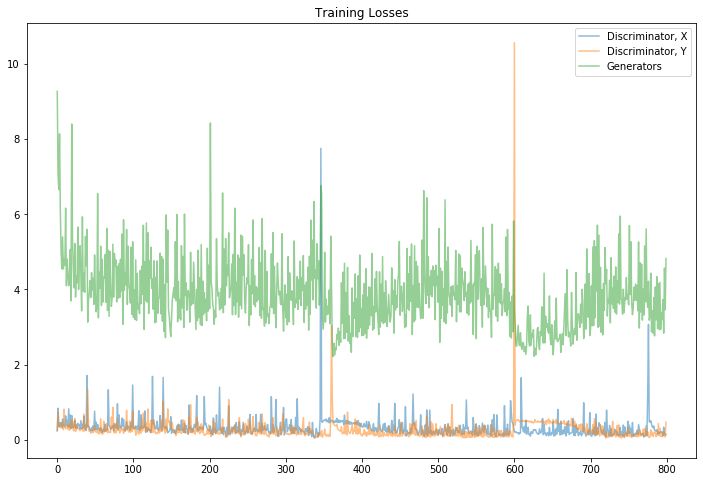

In [22]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [23]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')


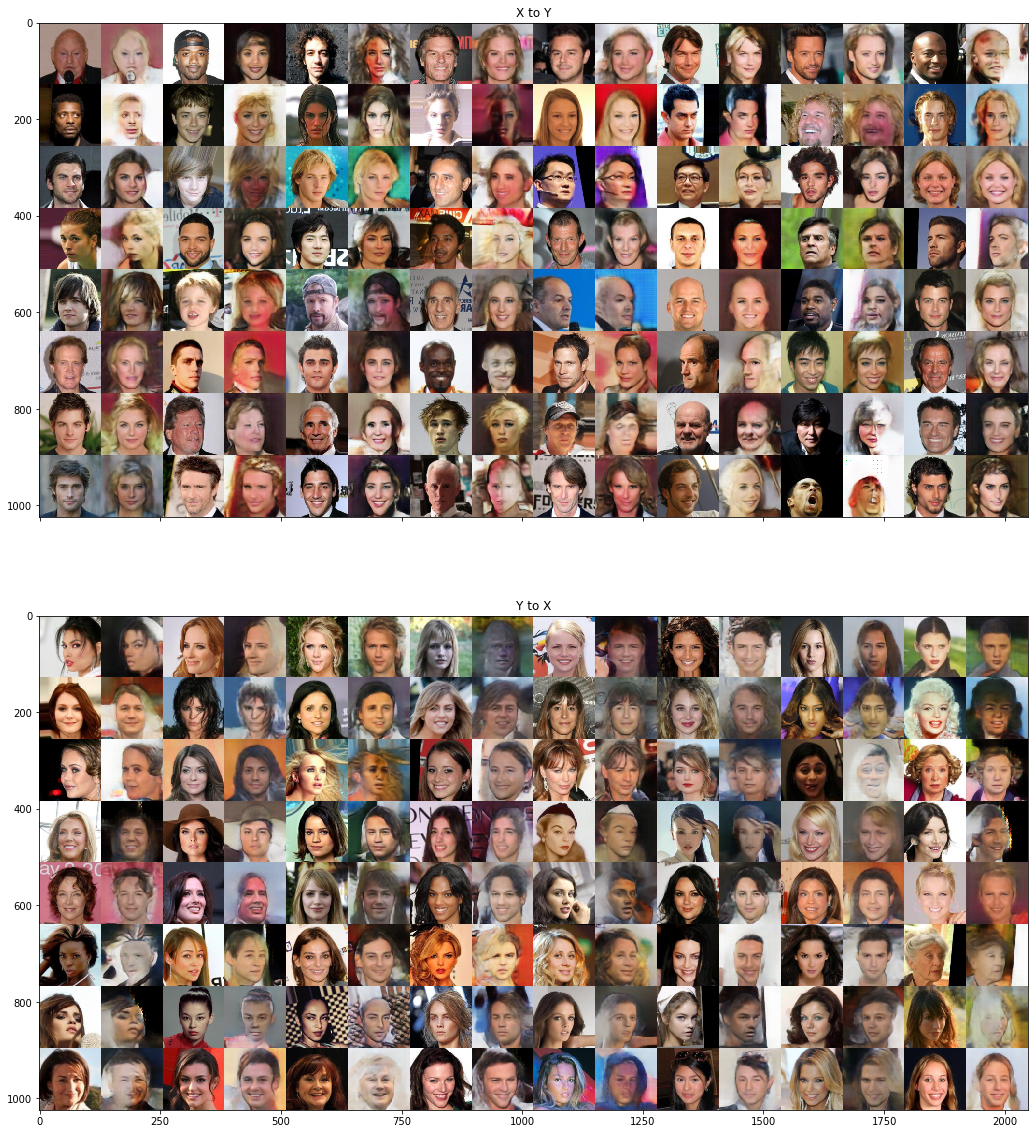

In [24]:
# view samples at iteration 4000
view_samples(7000, 'samples_cyclegan')